# Finding the next trendy neighborhood in chicago 


### Background
In larger cities old and neglected neighborhoods can quickly transform into a popular and trendy neighborhood with high real estate demand and sharp increase in the real state prices. If detected early, these areas can be a good real state investment opportunity. Some signs that can show a neighborhood is transforming are increase in the number of home renovations and new constructions, increase in the number of resturants and bars in the area, and decrease in the crime rate.

The goal of this project is to find the next trendy neighborhood using public data available from city of chicago data portal such as building permits, valid retail food licenses, and crime rate as well as the historical housing prices in each zipcode from Zillow.

### 1. [Importing and cleaning housing data](#Historical-Housing-Price):


1.1 [Importing data](#Historical-Housing-Price-importing-data)<br>
1.2 [Plotting](#Historical-Housing-Price-plotting)<br>
1.3 [Imputing missing values](#Historical-Housing-Price-imputing_missing_values)<br>

### 2. [Importing and cleaning construction data](#construction_data)
2.1 [Importing data](#construction-importing-data)<br>
2.2 [Missing values](#construction-missing-data)<br>
2.3 [Finding zipcode from lattitude and longitude](#construction-zipcode)<br>

### 3. [Importing and cleaning number of valid restaurants licenses](#restaurant-data)
3.1 [Importing data](#restaurant-importing-data)<br>
3.2 [Finding the number of valid retail food establishments per zipcode per year](#restaurant-cleaning)<br>
3.3 [Plotting](#restaurant-plotting)<br>

### 4. [Importing and cleaning crime data](#crime-data)
4.1 [Importing data](#crime-importing-data)<br>
4.2 [Missing values](#crime-missing-data)<br>
4.3 [Finding zipcode from lattitude and longitude](#crime-zipcode)<br>
4.4 [One hot encoding crime types](#crime-grouping)<br>
4.5 [Plotting](#crime-plotting)

### 5. [Zip code's area, population, and neighborhoods](#zipcode-data)
5.1 [Importing and cleaning data](#zipcode-data)<br>
5.2 [One hot encoding neighborhoods](#zipcode_neighborhoods)

### 6. [Merging all the data and further EDA](#merging-data) 
6.1 [Plotting relationship between price and other features](#price-vs-other-plot)<br>
6.2 [Correlation plots](#price-vs-other-correlation)

### 7. [Feature engineering](#feature-engineering)
### 8. [Test and train data splitting](#test-train-split)
### 9. [ML modeling](#modeling)
9.1 [Trying vanilla models](#vanilla-models)<br>
9.2 [Random forest model](#random-forest)<br>
9.3 [XGBOOST model](#xgboost)

### 10. [ARIMA modeling](Time_Series_SARIMAX.ipynb)
10.1 [autoarima](Time_Series_SARIMAX.ipynb#auto-arima-no-exog)<br>
10.1 [autoarima with exogenous variable](Time_Series_SARIMAX.ipynb#auto-arima-with-exog)

### 11. [Statistical significance](#statistical-significance)


Importing relavant libraries 

In [2]:
import glob, os
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import requests 
import json
from collections import defaultdict
import pickle
import requests
from bs4 import BeautifulSoup
from pandas_profiling import ProfileReport
from sodapy import Socrata
import dill
from geopy.geocoders import Nominatim
import geopy
from ediblepickle import checkpoint
from retrying import retry
import requests
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
import cloudscraper
from time import sleep
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
import altair as alt


In [3]:
sns.set()

# Historical Housing Price, 1996 to 2020
<a id=Historical-Housing-Price></a>

<a id=Historical-Housing-Price-importing-data></a>
Information on housing data is obtained from [Zillow](https://www.zillow.com/research/data/). The data includes historical monthly housing price data from 1996 to 2020 for all zip codes located in the United States. The data is seasonality adjusted. We only kept the data related to the city of Chicago and dropped the unrelated columns. The data includes information on 54 Chicago zip codes.

In [4]:
#reading the housing price data
Housing_price_since1996 = pd.read_csv('./Chicago_Housing_Datasets/All_cities_Monthly_HousingPrice_1996to2020.csv')
Housing_price_since1996 = Housing_price_since1996[Housing_price_since1996.City == 'Chicago']
Housing_price_since1996.drop(['CountyName', 'Metro', 'City', 'State', 'StateName', 'RegionType','SizeRank', 'RegionID'], axis=1, inplace=True)
Housing_price_since1996.rename(columns={'RegionName': 'zipcode'}, inplace=True)
Housing_price_since1996.reset_index(drop=True,inplace=True)
Housing_price_since1996.head(3)

,zipcode,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,...,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30
0,60657,203459.0,203308.0,202913.0,202782.0,202237.0,202415.0,202209.0,202796.0,203655.0,...,473138.0,474705.0,475762.0,475995.0,476428.0,477687.0,479702.0,482493.0,485306.0,488055.0
1,60614,271728.0,271479.0,270979.0,270842.0,270189.0,270275.0,269799.0,270340.0,271380.0,...,608666.0,609279.0,608927.0,608721.0,608756.0,609901.0,611415.0,614273.0,617081.0,620179.0
2,60640,120004.0,119659.0,119308.0,119195.0,118944.0,119065.0,119070.0,119736.0,120564.0,...,304818.0,306382.0,307129.0,307447.0,307954.0,309306.0,311171.0,313906.0,316627.0,319125.0


In [5]:
#all of the zipcodes with housing price information
Housing_price_since1996.zipcode.unique()

array([60657, 60614, 60640, 60647, 60618, 60613, 60625, 60629, 60610,
       60619, 60611, 60617, 60620, 60634, 60628, 60649, 60626, 60622,
       60616, 60615, 60641, 60660, 60637, 60608, 60638, 60639, 60630,
       60643, 60623, 60632, 60605, 60609, 60645, 60654, 60651, 60653,
       60644, 60607, 60612, 60659, 60652, 60631, 60656, 60624, 60601,
       60642, 60655, 60646, 60661, 60633, 60606, 60602, 60603, 60604])

In [6]:
#data cleaning
Housing_price_since1996 = Housing_price_since1996.melt(id_vars='zipcode', value_name='price', var_name='date')
print(Housing_price_since1996.dtypes)
Housing_price_since1996.head()

zipcode      int64
date        object
price      float64
dtype: object


,zipcode,date,price
0,60657,1996-01-31,203459.0
1,60614,1996-01-31,271728.0
2,60640,1996-01-31,120004.0
3,60647,1996-01-31,163786.0
4,60618,1996-01-31,198594.0


In [7]:
#data cleaning
Housing_price_since1996.zipcode = Housing_price_since1996.zipcode.astype(str)
Housing_price_since1996.date = pd.to_datetime(Housing_price_since1996.date, format='%Y-%m-%d')
Housing_price_since1996['year'] = Housing_price_since1996.date.dt.year
Housing_price_yearly = Housing_price_since1996.groupby(['year', 'zipcode'])['price'].mean().reset_index()
Housing_price_yearly.head()

,year,zipcode,price
0,1996,60601,190835.583333
1,1996,60602,203855.583333
2,1996,60603,NaN
3,1996,60604,NaN
4,1996,60605,174092.000000


In [8]:
Housing_price_yearly.groupby('year').mean().describe()

,price
count,25.000000
mean,257354.337279
std,57416.737073
min,145281.979482
25%,232050.495370
50%,267896.481481
75%,306174.253086
max,327330.483333


In [9]:
Housing_price_yearly[Housing_price_yearly.year==2016].sort_values(by='price')[:10]

,year,zipcode,price
1105,2016,60628,80009.250000
1096,2016,60617,99221.500000
1110,2016,60633,104021.833333
1102,2016,60624,110954.416667
1101,2016,60623,115736.166667
1112,2016,60637,116039.083333
1123,2016,60649,121258.250000
1119,2016,60644,127068.583333
1098,2016,60619,131397.666667
1099,2016,60620,135654.416667


### Plotting distribution of housing price for all zipcodes over time 
<a id=Historical-Housing-Price-plotting></a>

Looking at the housing price distribution over time for all the zipcodes in Chicago we can see that the price difference between the most expensive and teh cheapest housings increases over time. Showing that although all zipcodes saw an increase in housing price since 1996, in some zipcodes the housing value increased much more compared to the other zipcodes. We also can see the housing market crash starting 2008 and the median housing price has still not recovered to its value before the crash.

Text(0.5, 1.0, 'Housing price distributions for all zip codes for each year from 1996 to 2020')

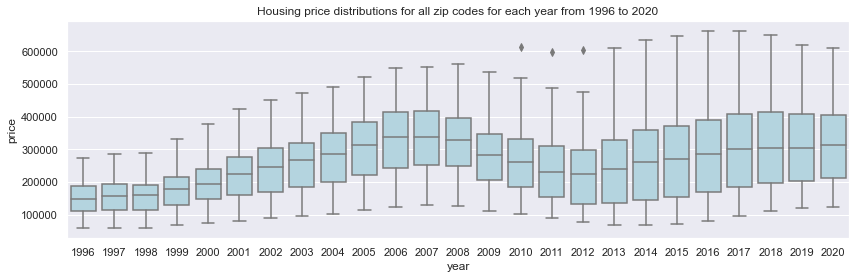

In [10]:
plt.figure(figsize=(14,4))
sns.boxplot(x='year', y='price', data=Housing_price_yearly.dropna(), color='lightblue')
plt.title('Housing price distributions for all zip codes for each year from 1996 to 2020')

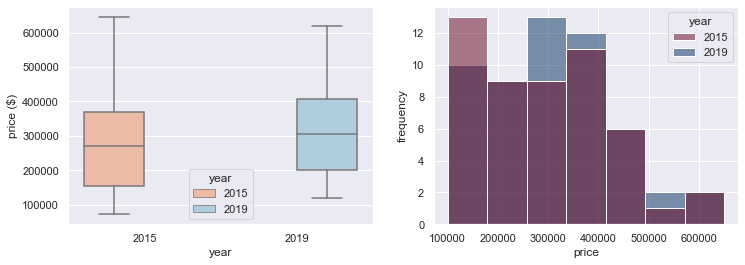

In [11]:
#housing price distribution
def plot_comparing_price_at_different_years(year1=2015, year2=2019):
    fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
    df = Housing_price_yearly.loc[(Housing_price_yearly.year==year1) | (Housing_price_yearly.year==year2)].dropna()
    sns.boxplot(y= 'price',data=df, x='year', color='lightblue', ax=ax1, hue='year', palette='RdBu')    
    ax1.set_ylabel('price ($)')
    ax1.set_xlabel('year')
    sns.histplot(x= 'price', data=df,color='blue', ax=ax2, binrange=[100000,650000], bins=7, hue='year', palette='RdBu')
    ax2.set_ylabel('frequency')
plot_comparing_price_at_different_years()

In [12]:
# creating a dataframe for each zipcode
dict_df_by_zip = defaultdict(str)
for zipcode, df in Housing_price_yearly.groupby('zipcode'):
    dict_df_by_zip[zipcode] = df
dict_df_by_zip['60601'].head(3)

,year,zipcode,price
0,1996,60601,190835.583333
54,1997,60601,193921.166667
108,1998,60601,202341.250000


### Imputing missing values
<a id=Historical-Housing-Price-imputing_missing_values></a>

There are 6 zipcodes that have missing values over some time intervals. To impute the missing values, we looked at the neighboring zipcodes and found the one or comination of the ones that best matched the housing price of the zipcode with missing values. We used the data to impute missing values.

In [13]:
#zipcodes with missing data
Housing_price_yearly[Housing_price_yearly.price.isna()].zipcode.unique()

array(['60603', '60604', '60623', '60624', '60651', '60661'], dtype=object)

In [14]:
#approximating the missing data for zipcodes based on the data from other zipcodes in the same neighborhood

In [15]:
missing_values_60623 = Housing_price_yearly.loc[Housing_price_yearly.zipcode.str.contains('60644|60609', regex=True)].groupby('year').mean().round()
missing_values_60603 = Housing_price_yearly.loc[Housing_price_yearly.zipcode.str.contains('60611', regex=True)].groupby('year').mean().round()+200000
missing_values_60604 = Housing_price_yearly.loc[Housing_price_yearly.zipcode.str.contains('60601|60602|60606', regex=True)].groupby('year').mean().round()
missing_values_60624 =Housing_price_yearly.loc[Housing_price_yearly.zipcode.str.contains('60612|60644', regex=True)].groupby('year').mean().round()
missing_values_60651 = Housing_price_yearly.loc[Housing_price_yearly.zipcode.str.contains('60644', regex=True)].groupby('year').mean().round()-5000
missing_values_60661 = Housing_price_yearly.loc[Housing_price_yearly.zipcode.str.contains('60607', regex=True)].groupby('year').mean().round()

In [16]:
dict_df_by_zip['60603'] = dict_df_by_zip['60603'].set_index('year').fillna(missing_values_60603).reset_index()
dict_df_by_zip['60604'] = dict_df_by_zip['60604'].set_index('year').fillna(missing_values_60604).reset_index()
dict_df_by_zip['60623'] = dict_df_by_zip['60623'].set_index('year').fillna(missing_values_60623).reset_index()
dict_df_by_zip['60624'] = dict_df_by_zip['60624'].set_index('year').fillna(missing_values_60624).reset_index()
dict_df_by_zip['60651'] = dict_df_by_zip['60651'].set_index('year').fillna(missing_values_60651).reset_index()
dict_df_by_zip['60661'] = dict_df_by_zip['60661'].set_index('year').fillna(missing_values_60661).reset_index()
dict_df_by_zip['60653'] = dict_df_by_zip['60653'].fillna(method='bfill')

In [17]:
#creating a dictionary with zipcodes as keys and yearly data for the zipcodes as values
def get_yearly_price_df(adict):
    yearly_df_by_zip = defaultdict(str)
    for key in dict_df_by_zip:
        yearly_df_by_zip[key]  = dict_df_by_zip[key].set_index('year')
    return yearly_df_by_zip
df_price_by_zipcode_yearly = get_yearly_price_df(dict_df_by_zip)        

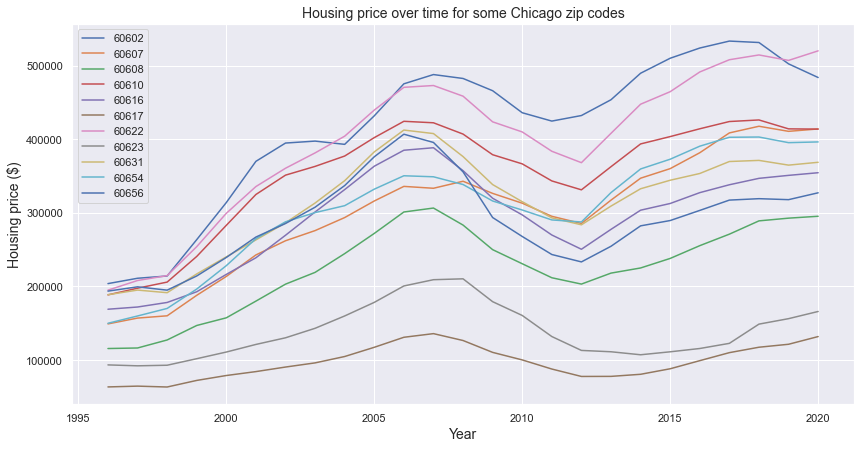

In [18]:
#plotting housing price over time for given zipcodes
def plot_price(adict, selected_zipcodes):
    fig, ax = plt.subplots(figsize=(14,7))
    for zipcode in selected_zipcodes:
        ax.plot(adict[zipcode].price, label=zipcode)
        plt.legend()
    plt.ylabel('Housing price ($)',{'fontsize': 14})
    plt.xlabel('Year',{'fontsize': 14})
    plt.title('Housing price over time for some Chicago zip codes',{'fontsize': 14})
    
selected_zipcodes = ['60602','60607', '60608', '60610', '60616', '60617','60622', '60623','60631', '60654', '60656']
plot_price(df_price_by_zipcode_yearly,selected_zipcodes)

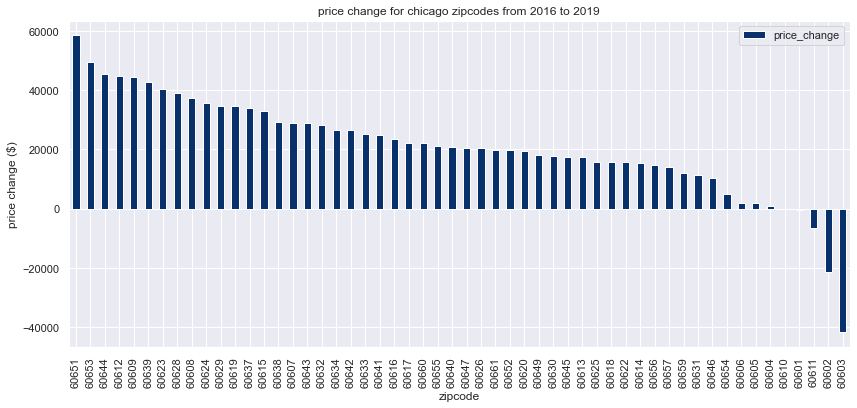

In [19]:
# plotting housing price change for all zipcodes: price at the end of 2019 - price at the beginning of 2014

def get_price_change(init_date = 2016, end_date = 2019):
    price_change = []
    for zipcode in Housing_price_yearly.zipcode.unique():
        df = df_price_by_zipcode_yearly[zipcode].reset_index()
        zipcode_price_change = df.loc[df.year==end_date, 'price'].values[0] - df.loc[df.year==init_date, 'price'].values[0]
        price_change.append((zipcode, zipcode_price_change))
    price_change_df = pd.DataFrame(price_change, columns=['zipcode', 'price_change'])
    price_change_df_sorted = price_change_df.sort_values('price_change', ascending=False)
    price_change_df_sorted.plot(x='zipcode',y='price_change',kind='bar', figsize=(14,6), cmap='Blues_r')
    plt.title(f'price change for chicago zipcodes from {init_date} to {end_date}')
    plt.ylabel('price change ($)')
    return price_change_df_sorted
price_change = get_price_change()


The plot shows some zipcodes such as 60651, 60612, 60639 had a significant value increase over the 5 year period while other zipcodes such as 60611 and 60604 had much less price increase 

# Construction and Renovation Permits Data
<a id=construction_data></a>

A building permit is required before beginning most construction, demolition, and repair work in Chicago. Permits issued by the Department of Buildings in the City of Chicago from 2006 to the present and the type of the permit is available from [City of Chicago Website](https://www.chicago.gov/city/en/depts/bldgs/dataset/building_permits.html). Here we retrieve the data using [Socrata Open Data API (SODA)](https://dev.socrata.com/foundry/data.cityofchicago.org/ydr8-5enu). 
We only used the data with permit type that showed more significant alteration such as "New Construction and Renovation" which includes new projects or rehabilitations of existing buildings, "Wrecking/Demolition" which includes private demolition of buildings and other structures, and "Renovation/Alteration". We did not include minor repairs such as electric wiring because that probably is not a sign of change in a neighborhood.
The data also includes the latitude and longitude of the construction site for each issued permit which we used to find the zipcode.

<a id=construction-importing-data></a>

In [20]:
#getting the data from city of chicago data portal: https://data.cityofchicago.org/
"""
client = Socrata("data.cityofchicago.org", None)
select = 'id, permit_, application_start_date, issue_date, street_number, street_name, community_area, census_tract, ward,latitude,longitude'
results = client.get("ydr8-5enu", select = select, where= "permit_type in ('PERMIT - NEW CONSTRUCTION','PERMIT - WRECKING/DEMOLITION','PERMIT - RENOVATION/ALTERATION')", limit=174534)
# Convert to pandas DataFrame
building = pd.DataFrame.from_records(results)
"""

'\nclient = Socrata("data.cityofchicago.org", None)\nselect = \'id, permit_, application_start_date, issue_date, street_number, street_name, community_area, census_tract, ward,latitude,longitude\'\nresults = client.get("ydr8-5enu", select = select, where= "permit_type in (\'PERMIT - NEW CONSTRUCTION\',\'PERMIT - WRECKING/DEMOLITION\',\'PERMIT - RENOVATION/ALTERATION\')", limit=174534)\n# Convert to pandas DataFrame\nbuilding = pd.DataFrame.from_records(results)\n'

In [21]:
#saving the data 
"""
with open("building_permit", "wb") as dill_file:
    dill.dump(building, dill_file)
"""

#reading the data 
with open("building_permit", "rb") as dill_file:
    building_permit = dill.load(dill_file)

In [22]:
building_permit.head(3)

,id,permit_,application_start_date,issue_date,street_number,street_name,community_area,census_tract,ward,latitude,longitude
0,2015693,100276612,2009-03-26T00:00:00.000,2010-06-14T00:00:00.000,5439,DAMEN,61,6117,16,41.794585511,-87.674174892
1,2053303,100293285,2009-06-16T00:00:00.000,2009-07-16T00:00:00.000,2946,HOYNE,5,514,1,41.935473196,-87.680810483
2,3125307,100876352,2020-10-14T00:00:00.000,2020-11-10T00:00:00.000,10000,OHARE,76,980000,41,NaN,NaN


In [23]:
building_permit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174534 entries, 0 to 174533
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   id                      174534 non-null  object
 1   permit_                 174534 non-null  object
 2   application_start_date  174374 non-null  object
 3   issue_date              174534 non-null  object
 4   street_number           174534 non-null  object
 5   street_name             174534 non-null  object
 6   community_area          145676 non-null  object
 7   census_tract            145171 non-null  object
 8   ward                    145640 non-null  object
 9   latitude                174058 non-null  object
 10  longitude               174058 non-null  object
dtypes: object(11)
memory usage: 14.6+ MB


In [24]:
#data cleaning
building_permit.application_start_date = pd.to_datetime(building_permit.application_start_date)
building_permit.issue_date = pd.to_datetime(building_permit.issue_date)
building_permit['year'] = building_permit.application_start_date.dt.year

<a id=construction-missing-data></a>
### Missing data 

The latitude and longitude information of each permit is necessary to find the zip code where the construction happend. There are 476 entries with missing latitude and longitude information. Because there is no other way to find the zip code, the entries with missing location information are dropped from the data.

In [25]:
#looking for data points with missing location information (latitude and longitude)
missing_lat_long = building_permit[(building_permit['latitude'].isna()) | (building_permit['longitude'].isna())]
print(missing_lat_long.shape)
missing_lat_long.head(3)

(476, 12)


,id,permit_,application_start_date,issue_date,street_number,street_name,community_area,census_tract,ward,latitude,longitude,year
2,3125307,100876352,2020-10-14,2020-11-10,10000,OHARE,76,980000,41,NaN,NaN,2020.0
3,3110706,100864812,2020-04-21,2020-07-01,10000,OHARE,76,980000,41,NaN,NaN,2020.0
23,3092615,100854411,2020-02-24,2020-05-01,10000,OHARE,76,980000,41,NaN,NaN,2020.0


In [26]:
#from 174534 entries the location data were missing for 476 entries. Removed the data with missing location
building_lat_long = building_permit[(building_permit['latitude'].notnull()) & (building_permit['longitude'].notnull())]
building_lat_long.head(3)

,id,permit_,application_start_date,issue_date,street_number,street_name,community_area,census_tract,ward,latitude,longitude,year
0,2015693,100276612,2009-03-26,2010-06-14,5439,DAMEN,61,6117,16,41.794585511,-87.674174892,2009.0
1,2053303,100293285,2009-06-16,2009-07-16,2946,HOYNE,5,514,1,41.935473196,-87.680810483,2009.0
4,2068267,100300715,2009-07-24,2009-08-31,2715,KENMORE,7,704,32,41.930475362,-87.654962896,2009.0


In [27]:
building_lat_long.dtypes

id                                object
permit_                           object
application_start_date    datetime64[ns]
issue_date                datetime64[ns]
street_number                     object
street_name                       object
community_area                    object
census_tract                      object
ward                              object
latitude                          object
longitude                         object
year                             float64
dtype: object

In [28]:
building_lat_long.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174058 entries, 0 to 174533
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      174058 non-null  object        
 1   permit_                 174058 non-null  object        
 2   application_start_date  173898 non-null  datetime64[ns]
 3   issue_date              174058 non-null  datetime64[ns]
 4   street_number           174058 non-null  object        
 5   street_name             174058 non-null  object        
 6   community_area          145297 non-null  object        
 7   census_tract            144810 non-null  object        
 8   ward                    145276 non-null  object        
 9   latitude                174058 non-null  object        
 10  longitude               174058 non-null  object        
 11  year                    173898 non-null  float64       
dtypes: datetime64[ns](2), float64(

<a id=construction-zipcode></a>

### Getting zipcode from lat, long data  


In [29]:
#getting the zipcode based on lat and long for each entry
"""def find_zipcode_local(df):
    zipcode = []
    for row in tqdm(df.itertuples()):
        response = requests.get('http://localhost:3000/?lat={}&long={}'.format(row.latitude, row.longitude))
        zipcode.append(response.json()['zip'])
    return zipcode
building_zipcodes = find_zipcode_local(building_lat_long)"""
#saved the zipcode data
"""with open('building_zipcodes', 'wb') as dill_file:
    dill.dump(building_zipcodes, dill_file)"""

"with open('building_zipcodes', 'wb') as dill_file:\n    dill.dump(building_zipcodes, dill_file)"

In [30]:
#reading the zipcode data and assigning it to the zipcode column 
with open('building_zipcodes', 'rb') as f:
    construction_zipcode = dill.load(f)
building_lat_long['zipcode'] = construction_zipcode

<ipython-input-30-006a6e8d731a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  building_lat_long['zipcode'] = construction_zipcode


In [31]:
#confirm that missing zipcodes are located outside of chicago
building_lat_long = building_lat_long.dropna(subset=['application_start_date'])
building_lat_long[building_lat_long.zipcode.isna()].head()

,id,permit_,application_start_date,issue_date,street_number,street_name,community_area,census_tract,ward,latitude,longitude,year,zipcode
1169,1648980,100093725,2006-02-02,2006-02-02,11601,TOUHY,NaN,NaN,NaN,42.008536401,-87.914428439,2006.0,None
1809,1668118,100105612,2006-04-20,2006-04-21,11601,TOUHY,NaN,NaN,NaN,42.008536401,-87.914428439,2006.0,None
3281,1722992,100136817,2006-09-13,2006-09-13,11601,TOUHY,NaN,NaN,NaN,42.008536401,-87.914428439,2006.0,None
3282,1723010,100136826,2006-09-13,2006-09-13,11601,TOUHY,NaN,NaN,NaN,42.008536401,-87.914428439,2006.0,None
3283,1723017,100136828,2006-09-13,2006-09-13,11601,TOUHY,NaN,NaN,NaN,42.008536401,-87.914428439,2006.0,None


In [32]:
#cleaning the data
building_df = building_lat_long.dropna(subset=['latitude', 'longitude'], axis=0).copy()
building_df.rename(columns={'permit_':'permit'}, inplace=True)
building_df['year'] = building_df['year'].astype(int)

<a id=construction-plot></a>
### Plotting 

We plotted the distribution of the number of issued permits for all zipcodes from 2004 to 2021. As can be seen, the data before 2006 is not complete and we only will be looking at the data after 2006. In each year there are few zipcodes that are outliers and have much more construction counts. Using the interactive plot we can see that zip codes 60647, 60618, and 60614 are the outlier zipcodes over few years. To have a better undrestanding of how much constructions in a zipcode change over time, we also plotted the the change in the number of permits issued for a given time period for all the zipcodes.

Text(0, 0.5, 'Number of issued construction permits')

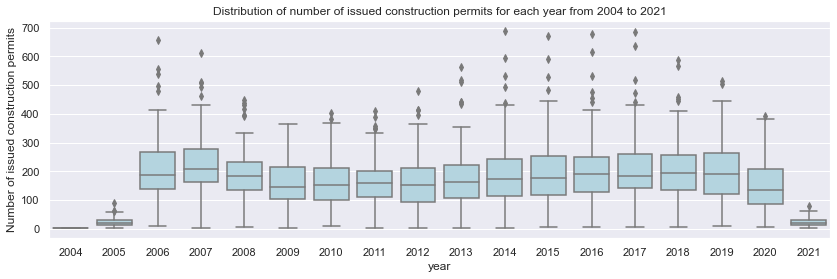

In [33]:
building_df_for_plot = building_df.groupby(['year', 'zipcode'])['permit'].count().reset_index()
plt.figure(figsize=(14,4))
sns.boxplot(x='year', y='permit', data=building_df_for_plot, color='lightblue')
plt.title('Distribution of number of issued construction permits for each year from 2004 to 2021')
plt.ylabel('Number of issued construction permits')

In [34]:
alt.Chart(building_df_for_plot).mark_circle(size=60).encode(
    x=alt.X('year:N', axis=alt.Axis(title='year')),
    y=alt.Y('permit:Q',axis=alt.Axis(title='number of issued permits')),
    color=alt.Color('zipcode:N', legend=None),

    tooltip=['year', 'permit', 'zipcode']
).properties(
    width=800,
    height=400,
    title= 'Number of issued construction permits for each zipcode from 2004 to 2021').interactive()

alt.Chart(...)

In [35]:
# In almost all years there are some outliers.

Text(0, 0.5, 'zipcode')

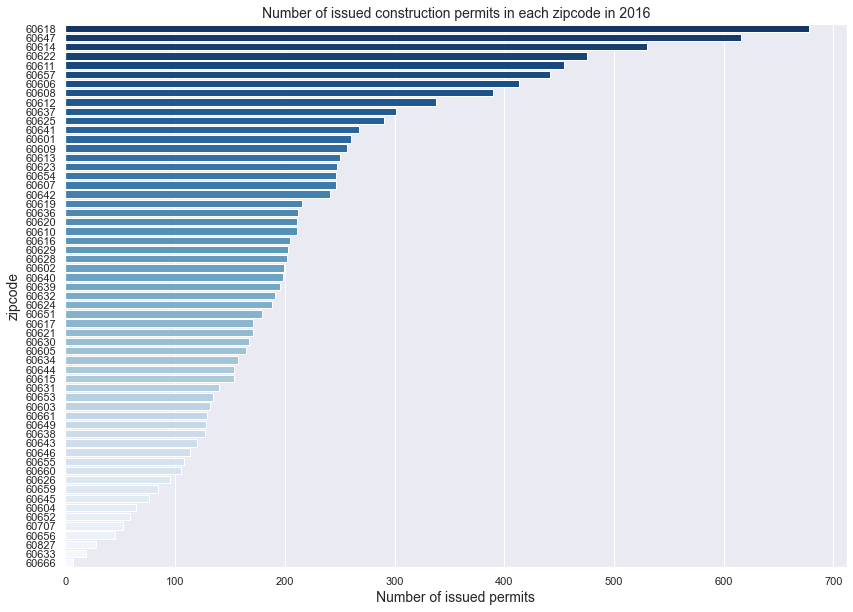

In [36]:
#plotting number of issued permits for all zipcodes for a given year
plt.figure(figsize=(14,10))
sns.barplot(x='permit', y='zipcode',data=building_df_for_plot.loc[building_df_for_plot.year==2016].sort_values(by='permit', ascending=False), palette='Blues_r')
plt.title('Number of issued construction permits in each zipcode in 2016',{'fontsize': 14})
plt.xlabel('Number of issued permits',{'fontsize': 14})
plt.ylabel('zipcode',{'fontsize': 14})

In [37]:
# building_df.to_csv('building_df')

In [38]:
# Finding yearly construction count per zipcode
df_construction_by_zipcode_yearly = defaultdict(str)
yearly_building_permits = building_df.groupby(['year', 'zipcode'])['permit'].count().reset_index()
yearly_building_permits['construction_count'] = yearly_building_permits.permit
yearly_building_permits.drop(['permit'], axis=1, inplace=True)
for zipcode, df in yearly_building_permits.groupby('zipcode'):
    df_construction_by_zipcode_yearly[zipcode]= df.reset_index(drop=True).set_index('year')
df_construction_by_zipcode_yearly['60628'].head()

,zipcode,construction_count
year,,
2005,60628,7
2006,60628,149
2007,60628,203
2008,60628,205
2009,60628,152


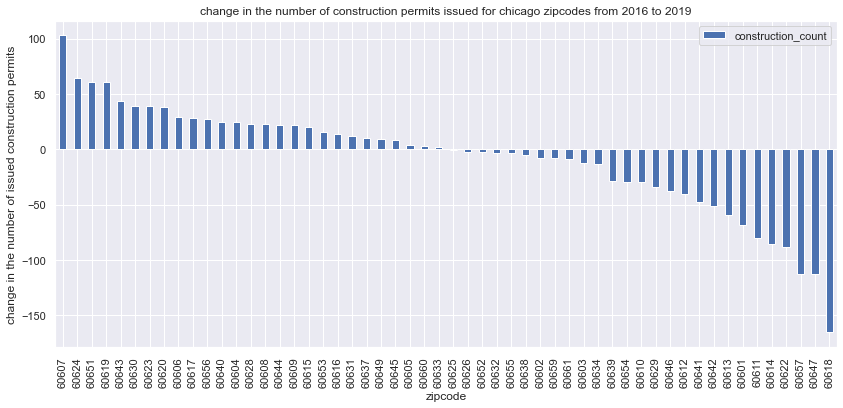

In [39]:
def get_construction_change(init_date = 2016, end_date = 2019):
    construction_change = []
    for zipcode in Housing_price_yearly.zipcode.unique():
        df = df_construction_by_zipcode_yearly[zipcode]
        zipcode_construction_change = df.loc[df.index ==end_date, 'construction_count'].sum() - df.loc[df.index ==init_date, 'construction_count'].sum()
        construction_change.append((zipcode, zipcode_construction_change))
    construction_df = pd.DataFrame(construction_change, columns=['zipcode', 'construction_count'])
    construction_df.sort_values('construction_count', ascending=False).plot(x='zipcode',kind='bar', figsize=(14,6))
    plt.title(f'change in the number of construction permits issued for chicago zipcodes from {init_date} to {end_date}')
    plt.ylabel('change in the number of issued construction permits')
    return price_change
construction_change = get_construction_change()

<a id=restaurant-data></a>
# Issued Restaurants license Data

Records of business licenses issued by the Department of Business Affairs and Consumer Protection in the City of Chicago from 2002 to the present is available at [Chicago Data Portal](https://data.cityofchicago.org/Community-Economic-Development/Business-Licenses/r5kz-chrr). We filtered and retrieved the data using [Socrata Open Data API](https://dev.socrata.com/foundry/data.cityofchicago.org/r5kz-chrr) to only include valid bussiness licensses with license code 1006 (Retail Food Establishment). A  Retail  Food  Establishment  License  is  required  any  time  perishable  food is prepared, served or sold to the public and includes restaurants, cafés, taverns, grocery stores, convenience stores and more. Increase in the number of restaurants and cafés in a neighborhood can be a good sign and showing that the neighborhood is becoming more popular. 

Looking at the license-start-date and expiration-date columns of the data, we can see that issued business licenses are valid for different periods of time. Busineses need to renew their license before the license expieration date. The id column of the data includes two parts. The first part is the unique id, identifyng each business and the second part is related to the issued license for a given year. We seperated the unique business id and saved it as reataurant_id column. For each unique business we found the earliest year in the license-start-date column and the latest year in the expiration_date column to find the period of time for which the business holds a valid license. Then for each year from 1996 to 2024, we added a column to the data frame and for each business we added value 1 for the years at which the business was open and 0 for all the other years. Then we found the number of businesses in each year in each zipcode.

<a id=restaurant-importing-data></a>

In [40]:
#getting the issued licenses information from city of chicago data portal: data.cityofchicago.org
"""
client = Socrata("data.cityofchicago.org", None)
results = client.get("r5kz-chrr", select= 'id, legal_name, city, zip_code, ward, license_code, license_description, license_start_date, expiration_date, date_issued', where='license_code=1006',limit=1000000)
# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)"""

#saving the data
"""with open("resturants", "wb") as dill_file:
    dill.dump(results_df, dill_file)  
"""

'with open("resturants", "wb") as dill_file:\n    dill.dump(results_df, dill_file)  \n'

In [41]:
#reading the data
with open('resturants', 'rb') as f:
    restaurants = dill.load(f)
restaurants.head(3)   

,id,legal_name,city,zip_code,ward,license_code,license_description,license_start_date,expiration_date,date_issued
0,2437540-20180316,"WARM BELLY BAKERY, LLC",CHICAGO,60607,25,1006,Retail Food Establishment,2018-03-16T00:00:00.000,2021-07-15T00:00:00.000,2018-02-13T00:00:00.000
1,2595174-20200416,HOSPITALITY 201 LLC,CHICAGO,60622,1,1006,Retail Food Establishment,2020-04-16T00:00:00.000,2022-04-15T00:00:00.000,2020-11-13T00:00:00.000
2,2359449-20201216,"CO CO VIETNAMESE SANDWICHES, INC.",CHICAGO,60640,47,1006,Retail Food Establishment,2020-12-16T00:00:00.000,2022-12-15T00:00:00.000,2020-11-13T00:00:00.000


In [42]:
#cleaning the data
restaurants.license_start_date = pd.to_datetime(restaurants.license_start_date)
restaurants.expiration_date = pd.to_datetime(restaurants.expiration_date)
restaurants.date_issued = pd.to_datetime(restaurants.date_issued)
restaurants.dropna(subset=['license_start_date', 'zip_code'], inplace=True)

In [43]:
#looking for missing values
restaurants.isna().any()

id                     False
legal_name             False
city                   False
zip_code               False
ward                    True
license_code           False
license_description    False
license_start_date     False
expiration_date        False
date_issued            False
dtype: bool

In [44]:
#extracting restaurants unique license number from the id column 
id_df = restaurants.id.str.extract('(\d+)-')
id_df.rename(columns = {0:'restaurant_id'}, inplace=True)
id_df['start_year'] = restaurants.license_start_date.dt.year.astype(int)
id_df['end_year'] = restaurants.expiration_date.dt.year.astype(int)
id_df['zipcode'] = restaurants.zip_code
id_df.head(3)

,restaurant_id,start_year,end_year,zipcode
0,2437540,2018,2021,60607
1,2595174,2020,2022,60622
2,2359449,2020,2022,60640


In [45]:
#finding the time period for which restaurants had valid license at each zipcode 
id_year_zip_df = id_df.groupby(['restaurant_id','zipcode']).agg({'start_year':min, 'end_year':max})
id_year_zip_df.head()

,,start_year,end_year
restaurant_id,zipcode,,
100,60603,2002,2006
1000049,60607,2002,2018
1000125,60622,2002,2016
1000160,60655,2002,2004
1000200,60639,2002,2007


In [46]:
#adding each year from 1996 to 2024 as a column to the dataframe 
id_year_zip_df
for i in range(1996, 2024):
    year = str(i)
    id_year_zip_df[year] = 0
id_year_zip_df = id_year_zip_df.reset_index().sort_values('start_year')
id_year_zip_df.head()

,restaurant_id,zipcode,start_year,end_year,1996,1997,1998,1999,2000,2001,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
35340,56513,60607,1996,1997,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35261,55401,60631,1996,1997,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32525,31870,60639,1996,1997,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35030,52789,46410,1996,1997,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35297,55920,60643,1996,1997,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
#for each year that the business was open, 1 is placed in the dataframe for that business/year
def add_year_info(row):
    for year in range(row['start_year'], row['end_year']+1):
        row[str(year)] = 1
    return row

In [48]:
# is there a more efficient way to do this?
id_year_zip_df = id_year_zip_df.apply(add_year_info, axis=1)
id_year_zip_df.loc[id_year_zip_df.zipcode=='60607'].head()

,restaurant_id,zipcode,start_year,end_year,1996,1997,1998,1999,2000,2001,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
35340,56513,60607,1996,1997,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1217,1140774,60607,2001,2022,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,0
1229,1141204,60607,2001,2003,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
36751,75178,60607,2001,2002,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1409,1144650,60607,2001,2017,0,0,0,0,0,1,...,1,1,1,1,0,0,0,0,0,0


In [49]:
#finding the total number of issued licenses for each zipcode for each year
df_resturant_info = id_year_zip_df.drop(['restaurant_id', 'start_year', 'end_year'], axis=1).copy()
restaurant_df = df_resturant_info.melt(id_vars='zipcode', value_name='restaurant_count', var_name='year')
restaurant_df = restaurant_df.groupby(['year', 'zipcode'])['restaurant_count'].sum().reset_index()
restaurant_df.year = restaurant_df.year.astype(int)
restaurant_df.head()

,year,zipcode,restaurant_count
0,1996,11572,0
1,1996,46218,0
2,1996,46322,0
3,1996,46410,1
4,1996,60007,0


In [50]:
restaurant_df.restaurant_count = restaurant_df.restaurant_count.astype(float)

In [51]:
restaurant_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2688 entries, 0 to 2687
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              2688 non-null   int64  
 1   zipcode           2688 non-null   object 
 2   restaurant_count  2688 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 63.1+ KB


In [52]:
# restaurant_df.to_csv('restaurant_df', index=False)

### Plotting
<a id=restaurant-plotting></a>
We can see the yearly distribution of valid business licenses is almost uniform over time. We will only use the data from 2006 to 2019. The data for years 2021 and later show the number of licenses that will be valid until that then but does not represent the total number of valid licenses and hence it's not useful in this project. We also showed the number of valid licenses for each zipcode in an interactive plot to better follow the trends in each zipcode. 

We plotted the change in the number of valid businesses for a given time period. In this plot we can clearly see that the number of businesses in some zip codes such as 60654 60611 60607 increased from 2014 to 2019 however, some zip codes such as 60610, 60619, and 60623 lost some businesses.

Text(0, 0.5, 'Number of valid restaurant licenses')

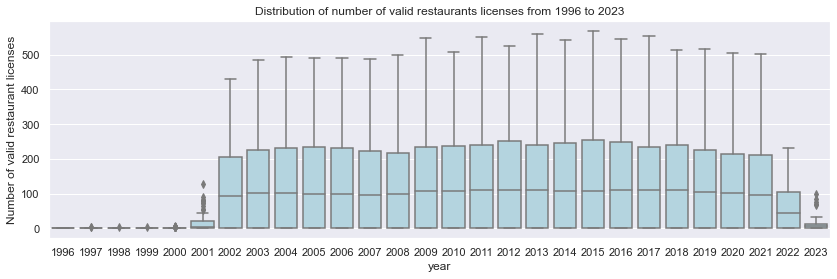

In [53]:
plt.figure(figsize=(14,4))
sns.boxplot(x='year', y='restaurant_count', data=restaurant_df, color='lightblue')
plt.title('Distribution of number of valid restaurants licenses from 1996 to 2023')
plt.ylabel('Number of valid restaurant licenses')

In [54]:
alt.Chart(restaurant_df).mark_line(size=1.2, point=True).encode(
    x=alt.X('year:N', axis=alt.Axis(title='year')),
    y=alt.Y('restaurant_count:Q',axis=alt.Axis(title='number of issued permits')),
    color=alt.Color('zipcode:N'),

    tooltip=['year', 'restaurant_count', 'zipcode']
).properties(
    width=800,
    height=600,
    title= 'Number of issued construction permits for each zipcode from 2004 to 2021').interactive()

alt.Chart(...)

Text(0, 0.5, 'Number of valid restaurant licenses')

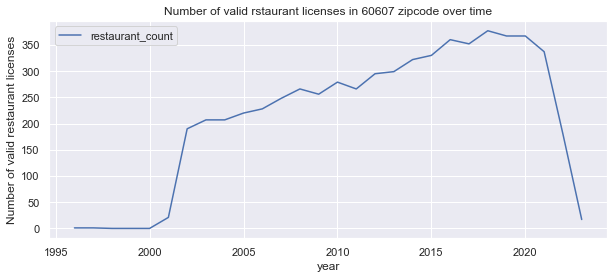

In [55]:
#finding yearly count of valid restaurants licenses for each zipcode
df_restaurants_by_zipcode_yearly = defaultdict(str)
for zipcode, df in restaurant_df.groupby('zipcode'):
#     try:
#         zipcode_area = zipcode_extra_info.loc[zipcode_extra_info.zipcode==zipcode, 'Area of Zip Code'].values[0]
#         df.restaurant_count = df.restaurant_count/zipcode_area
#     except:
#         df = df*0
    df_restaurants_by_zipcode_yearly[zipcode] = df.reset_index(drop=True).set_index('year')
df_restaurants_by_zipcode_yearly['60607'].plot(figsize=(10,4))
plt.title('Number of valid rstaurant licenses in 60607 zipcode over time')
plt.ylabel('Number of valid restaurant licenses')

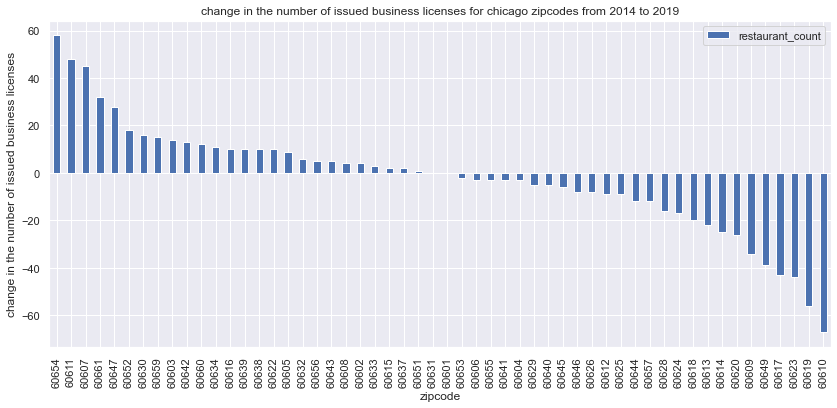

In [56]:
def get_restaurant_change(init_date = 2014, end_date = 2019):
    restaurant_change = []
    for zipcode in Housing_price_yearly.zipcode.unique():
        df = df_restaurants_by_zipcode_yearly[zipcode]
        zipcode_restaurant_change = df.loc[df.index ==end_date, 'restaurant_count'].sum() - df.loc[df.index ==init_date, 'restaurant_count'].sum()
        restaurant_change.append((zipcode, zipcode_restaurant_change))
    restaurant_df = pd.DataFrame(restaurant_change, columns=['zipcode', 'restaurant_count'])
    restaurant_df.sort_values('restaurant_count', ascending=False).plot(x='zipcode',kind='bar', figsize=(14,6))
    plt.title(f'change in the number of issued business licenses for chicago zipcodes from {init_date} to {end_date}')
    plt.ylabel('change in the number of issued business licenses')
    return restaurant_change
restaurant_change = get_restaurant_change()

<a id=crime-importing-data></a>
# Crime data

The crime data was obtained from [City of Chicago Data Portal](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2). This dataset reflects reported incidents of crime (with the exception of murders where data exists for each victim) that occurred in the City of Chicago from 2001 to present, minus the most recent seven days. Data is extracted from the Chicago Police Department's CLEAR (Citizen Law Enforcement Analysis and Reporting) system.

In [57]:
#getting the crime data from city of chicago open portal:  data.cityofchicago.org
"""client = Socrata("data.cityofchicago.org", None)
select = 'id, date, primary_type, description, location_description, arrest, domestic, year, latitude, longitude'
results = client.get("ijzp-q8t2",select=select, limit=7301707)
# Convert to pandas DataFrame
crime_results = pd.DataFrame.from_records(results)"""

#saving the data 
"""with open("chicago_crime_2001_2020", "wb") as dill_file:
    dill.dump(crime_results, dill_file)"""

'with open("chicago_crime_2001_2020", "wb") as dill_file:\n    dill.dump(crime_results, dill_file)'

In [58]:
#reading the data 
with open("chicago_crime_2001_2020", "rb") as f:
    crime= dill.load(f)
crime[100:105]

,id,date,primary_type,description,location_description,arrest,domestic,year,latitude,longitude
100,10224858,2015-09-05T16:42:00.000,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,True,True,2015,41.754256108,-87.569940704
101,10224860,2015-09-05T16:20:00.000,THEFT,$500 AND UNDER,RESIDENCE,False,False,2015,41.910284848,-87.766771965
102,10224861,2015-09-02T07:00:00.000,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,2015,41.754949629,-87.55997485
103,10224862,2015-09-05T16:13:00.000,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE PORCH/HALLWAY,False,True,2015,41.895647706,-87.758067814
104,10224863,2015-09-05T16:01:00.000,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,2015,41.771447416,-87.685868399


In [59]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7301707 entries, 0 to 7301706
Data columns (total 10 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   id                    object
 1   date                  object
 2   primary_type          object
 3   description           object
 4   location_description  object
 5   arrest                bool  
 6   domestic              bool  
 7   year                  object
 8   latitude              object
 9   longitude             object
dtypes: bool(2), object(8)
memory usage: 459.6+ MB


<a id=crime-missing-data></a>
### Missing values 

The crime location is required for this project and because there is no other way of finding the zip code information for data entries with missing lattitude and longitude we dropped those columns.

In [60]:
#dropping data entries for which the location data (lat and long) were missing
# crime.drop(['date', 'location_description'], axis=1, inplace=True)
crime_df = crime[(crime.latitude.notnull()) & (crime.longitude.notnull())]
crime_df['year'] = crime_df.year.astype(int)
crime_df.head()

<ipython-input-60-c2a6c1d2d734>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_df['year'] = crime_df.year.astype(int)


,id,date,primary_type,description,location_description,arrest,domestic,year,latitude,longitude
0,10224738,2015-09-05T13:30:00.000,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,2015,41.815117282,-87.669999562
1,10224739,2015-09-04T11:30:00.000,THEFT,POCKET-PICKING,CTA BUS,False,False,2015,41.895080471,-87.765400451
3,10224740,2015-09-05T12:45:00.000,NARCOTICS,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,2015,41.937405765,-87.716649687
4,10224741,2015-09-05T13:00:00.000,ASSAULT,SIMPLE,APARTMENT,False,True,2015,41.881903443,-87.755121152
5,10224742,2015-09-05T10:55:00.000,BURGLARY,FORCIBLE ENTRY,RESIDENCE,False,False,2015,41.744378879,-87.658430635


<a id=crime-zipcode></a>
### Finding zipcode of the crime location based on lattitude and longitude

In [61]:
#finding the zipcode from lat and long information
"""
def find_zipcode_local(lat, long):
    response = requests.get('http://localhost:3000/?lat={}&long={}'.format(lat,long))
    zipcode = response.json()['zip']
    return zipcode

lat = list(crime_df.latitude)
long = list(crime_df.longitude)
results = []
for i in tqdm(range(len(lat))):
    results.append(find_zipcode_local(lat[i], long[i]))
"""
"""with open("crime_zipcode", "wb") as dill_file:
    dill.dump(results, dill_file)"""

#saving the zipcode data
"""with open("crime_data_zipcode_backup.txt", "wb") as fp:
    pickle.dump(results, fp)"""

'with open("crime_data_zipcode_backup.txt", "wb") as fp:\n    pickle.dump(results, fp)'

In [62]:
#reading the zipcode data and assign it to the zipcode column of the crime dataframe
with open("crime_zipcode", "rb") as f:
    crime_zipcode_data =dill.load(f)
crime_df['zipcode'] = crime_zipcode_data
crime_df = crime_df.dropna(subset=['zipcode'], axis=0)
crime_df.head()

<ipython-input-62-049c6eb613ca>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_df['zipcode'] = crime_zipcode_data


,id,date,primary_type,description,location_description,arrest,domestic,year,latitude,longitude,zipcode
0,10224738,2015-09-05T13:30:00.000,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,2015,41.815117282,-87.669999562,60609
1,10224739,2015-09-04T11:30:00.000,THEFT,POCKET-PICKING,CTA BUS,False,False,2015,41.895080471,-87.765400451,60651
3,10224740,2015-09-05T12:45:00.000,NARCOTICS,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,2015,41.937405765,-87.716649687,60618
4,10224741,2015-09-05T13:00:00.000,ASSAULT,SIMPLE,APARTMENT,False,True,2015,41.881903443,-87.755121152,60644
5,10224742,2015-09-05T10:55:00.000,BURGLARY,FORCIBLE ENTRY,RESIDENCE,False,False,2015,41.744378879,-87.658430635,60620


<a id=crime-grouping></a>
The primary_type column describes the crime type. We grouped the crimes into categories to reduce the total number of crime features in the data. To one hot encode the crime types in the primary_type columns, we first created a dictionary to group all the crime types that are in the same category together and then turned that into a dataframe using DictVectorizer. We then merged that datafarme with the original crime dataframe.

In [63]:
# One Hot enocode crime type in the primary_type column, keeping some crime types together as a group.
def get_crime_type(row):
    crime_type_dict = defaultdict(str)
    if type(row) == str:
        if row in ('CRIM SEXUAL ASSAULT', 'CRIMINAL SEXUAL ASSAULT', 'SEX OFFENSE'):
            crime_type_dict['SEX OFFENSE']=1
        elif row in ('PUBLIC INDECENCY','PUBLIC PEACE VIOLATION', 'RITUALISM', 'OBSCENITY', 'PROSTITUTION'):
            crime_type_dict['PUBLIC INDECENCY']=1
        elif row in ('OTHER OFFENSE', 'NON-CRIMINAL (SUBJECT SPECIFIED)','NON - CRIMINAL', 'NON-CRIMINAL','INTERFERENCE WITH PUBLIC OFFICER', 'INTIMIDATION','STALKING'):
            crime_type_dict['OTHER']=1
        elif row in ('OTHER NARCOTIC VIOLATION', 'NARCOTICS'): 
            crime_type_dict['NARCOTICS']=1 
        else:
            crime_type_dict[row]=1
    return crime_type_dict
        

In [64]:
dict_vectorizer = DictVectorizer(sparse=False)
crime_types = dict_vectorizer.fit_transform(crime_df.primary_type.apply(get_crime_type))
crime_type_df = pd.DataFrame(crime_types, columns = dict_vectorizer.get_feature_names())
crime_type_df.head()

,ARSON,ASSAULT,BATTERY,BURGLARY,CONCEALED CARRY LICENSE VIOLATION,CRIMINAL DAMAGE,CRIMINAL TRESPASS,DECEPTIVE PRACTICE,DOMESTIC VIOLENCE,GAMBLING,...,LIQUOR LAW VIOLATION,MOTOR VEHICLE THEFT,NARCOTICS,OFFENSE INVOLVING CHILDREN,OTHER,PUBLIC INDECENCY,ROBBERY,SEX OFFENSE,THEFT,WEAPONS VIOLATION
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
crime_type_df.sum().sort_values(ascending=False)

THEFT                                1513694.0
BATTERY                              1329307.0
CRIMINAL DAMAGE                       825470.0
NARCOTICS                             725955.0
OTHER                                 474454.0
ASSAULT                               460728.0
BURGLARY                              406779.0
MOTOR VEHICLE THEFT                   332858.0
DECEPTIVE PRACTICE                    295175.0
ROBBERY                               272247.0
CRIMINAL TRESPASS                     204563.0
PUBLIC INDECENCY                      120080.0
WEAPONS VIOLATION                      87449.0
SEX OFFENSE                            55349.0
OFFENSE INVOLVING CHILDREN             47910.0
GAMBLING                               14486.0
LIQUOR LAW VIOLATION                   14325.0
ARSON                                  12167.0
HOMICIDE                               10943.0
KIDNAPPING                              6930.0
CONCEALED CARRY LICENSE VIOLATION        703.0
HUMAN TRAFFIC

In [66]:
#adding the crime type data to the rest of the crime df
crime_df_daily = pd.concat((crime_df, crime_type_df),axis=1)
# crime_df_daily = crime_df_daily[['year','zipcode','HOMICIDE', 'THEFT', 'BATTERY', 'NARCOTICS','BURGLARY', 'ROBBERY', 'CRIMINAL DAMAGE']]
crime_df_daily = crime_df_daily[['year','zipcode','THEFT', 'BATTERY', 'CRIMINAL DAMAGE','NARCOTICS','OTHER','ASSAULT','BURGLARY','MOTOR VEHICLE THEFT','DECEPTIVE PRACTICE'
,'ROBBERY','CRIMINAL TRESPASS','PUBLIC INDECENCY','WEAPONS VIOLATION','SEX OFFENSE','OFFENSE INVOLVING CHILDREN', 'HOMICIDE']]
crime_df_daily.head(3)

,year,zipcode,THEFT,BATTERY,CRIMINAL DAMAGE,NARCOTICS,OTHER,ASSAULT,BURGLARY,MOTOR VEHICLE THEFT,DECEPTIVE PRACTICE,ROBBERY,CRIMINAL TRESPASS,PUBLIC INDECENCY,WEAPONS VIOLATION,SEX OFFENSE,OFFENSE INVOLVING CHILDREN,HOMICIDE
0,2015.0,60609,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2015.0,60651,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
crime_df_daily = crime_df_daily.dropna()

<a id=crime-plotting></a>
### Plotting 
We plotted the theft count distribution over time and we can see clearly that overall the number of theft incidents has decreased over time. To see how different crime types have changed over time for a specific zipcode, we plotted bar plots of 7 different crime types for zip codes 60603, 60604, 60653, and 60612. Zip code 60603 has seen a decrease in housing value over the last 5 years and we can see from the plot below that crime rate has increased in this zipcode over this time period. Housing price value increased only slightly over the last 5 years and we can see the crime rate for this zip code has increase as well. Zip codes 60653 and 60612 were among the zip codes that saw the maximum increase the housing value over this time period and we can see that the crime rate has decreased for these zipcodes.  

The interactive Chicago crime map aslo shows more crime incidence for 2019 in the 60603 and 60604 zipcodes.

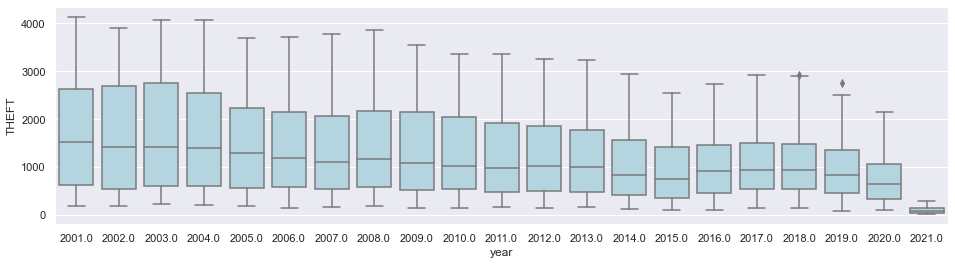

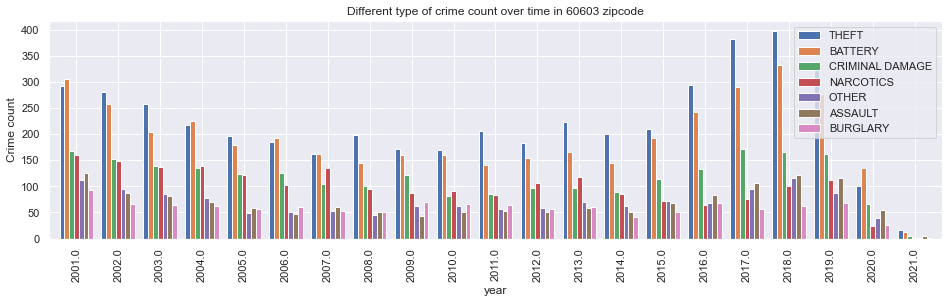

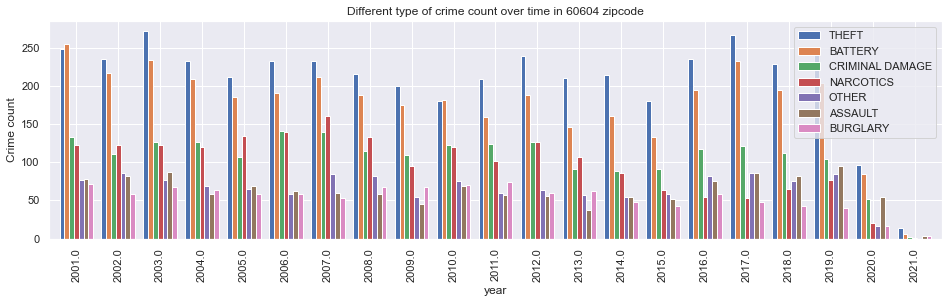

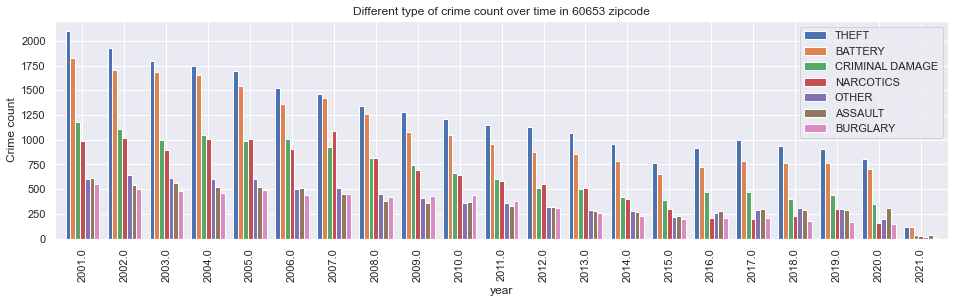

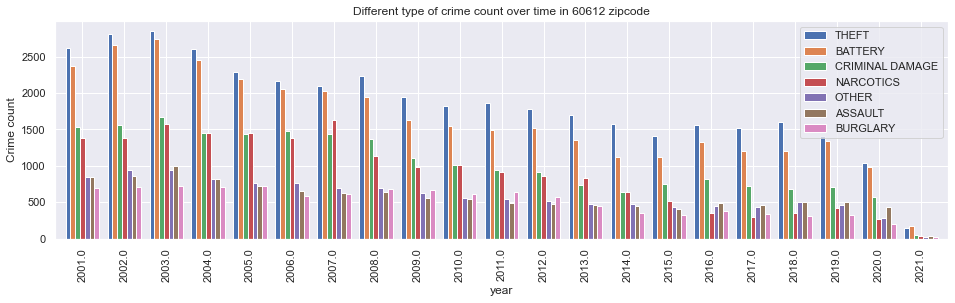

In [68]:
def plot_crime_distribution(crime_type ='THEFT'):
    crime_df_for_plot = crime_df_daily.groupby(['year','zipcode']).sum().reset_index()
    plt.figure(figsize=(16,4))
    sns.boxplot(x='year', y=crime_type, data=crime_df_for_plot, color='lightblue') 
plot_crime_distribution()

crime_df_for_plot = crime_df_daily.groupby(['zipcode','year']).sum().reset_index()
def plot_crime_for_zipcode(zipcode):
    crime_df_for_plot.loc[crime_df_for_plot.zipcode==zipcode,['year','THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'NARCOTICS', 'OTHER', 'ASSAULT', 'BURGLARY']].plot(x='year',kind='bar', figsize=(16,4),width=0.8)
    plt.title(f'Different type of crime count over time in {zipcode} zipcode')
    plt.ylabel('Crime count')
plot_crime_for_zipcode('60603')
plot_crime_for_zipcode('60604')
plot_crime_for_zipcode('60653')
plot_crime_for_zipcode('60612')

In [69]:
def download_json():
    '''Downloads ANC JSON from Open Data DC'''
    url = "https://raw.githubusercontent.com/smartchicago/chicago-atlas/master/db/import/zipcodes.geojson"
    resp = requests.get(url)
    return resp.json()

def gen_base(geojson):
    '''Generates baselayer of DC ANC map'''
    base = alt.Chart(alt.Data(values=geojson)).mark_geoshape(
        fill="lightgray",
        stroke='black',
        strokeWidth=1
    ).encode(
    ).properties(
        width=600,
        height=600
    )
    return base

def gen_points(year = 2019):
    points = alt.Chart(crime_df[crime_df.year==year].sample(5000)).mark_circle(
        size=10,opacity=0.95).encode(
        longitude='longitude:Q',
        latitude='latitude:Q',
        tooltip=['primary_type:N','zipcode'],
        color=alt.Color('primary_type',scale=alt.Scale(scheme='turbo'))
    ).properties(title= 'Chicago crime map in {}'.format(year))
    return points

anc_json = download_json()
base_layer = gen_base(geojson=anc_json)
points_layer = gen_points()
(base_layer + points_layer).configure_view(stroke=None)

alt.LayerChart(...)

In [70]:
# crime_df_daily = crime_df_daily.to_csv('crime_df_daily',index=False)

In [71]:
# seperating yearly data related to each zipcode and save it as a dataframe in a dictionary
df_crime_by_zipcode_yealy = defaultdict(str)
for zipcode, df in crime_df_daily.groupby('zipcode'):
    temp_df = df.groupby('year').sum()
#     try:
#         zipcode_Population = zipcode_extra_info.loc[zipcode_extra_info.zipcode==zipcode, 'Population'].values[0]
#         temp_df = temp_df/zipcode_Population
#     except:
#         temp_df = temp_df*0
    temp_df['zipcode'] = zipcode
    df_crime_by_zipcode_yealy[zipcode] = temp_df[['zipcode','NARCOTICS', 'HOMICIDE', 'WEAPONS VIOLATION', 'DECEPTIVE PRACTICE']]
df_crime_by_zipcode_yealy['60608'].head()


,zipcode,NARCOTICS,HOMICIDE,WEAPONS VIOLATION,DECEPTIVE PRACTICE
year,,,,,
2001.0,60608,1324.0,21.0,119.0,372.0
2002.0,60608,1114.0,93.0,104.0,360.0
2003.0,60608,1311.0,16.0,105.0,358.0
2004.0,60608,1414.0,12.0,108.0,334.0
2005.0,60608,1368.0,19.0,107.0,340.0


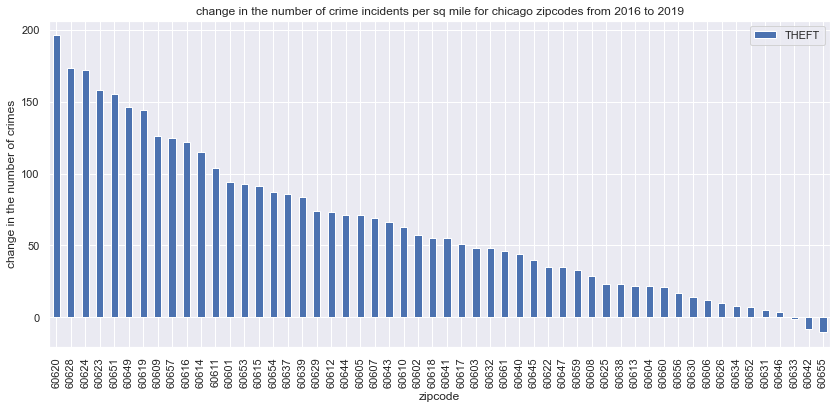

In [72]:
def get_crime_change(init_date = 2016, end_date = 2019):
    crime_change = []
    for zipcode in Housing_price_yearly.zipcode.unique():
        df = df_crime_by_zipcode_yealy[zipcode]
        zipcode_crime_change = df.loc[df.index ==end_date, 'NARCOTICS'].sum() - df.loc[df.index ==init_date, 'NARCOTICS'].sum()
        crime_change.append((zipcode, zipcode_crime_change))
    crime_df = pd.DataFrame(crime_change, columns=['zipcode', 'THEFT'])
    crime_df.sort_values('THEFT', ascending=False).plot(x='zipcode',kind='bar', figsize=(14,6))
    plt.title(f'change in the number of crime incidents per sq mile for chicago zipcodes from {init_date} to {end_date}')
    plt.ylabel('change in the number of crimes')
    return crime_change
crime_change = get_crime_change()

<a id=zipcode-data></a>

# More detailed data on zipcodes 

In [73]:
# getting zipcode data
"""scraper = cloudscraper.create_scraper()
def send_get_data(zipcode):
    res = scraper.get('https://zip-codes.cybo.com/united-states/{}_chicago/'.format(zipcode))
    if res.status_code == 200:
        soup = BeautifulSoup(res.text)
        dict_zipcode = {i.text.replace(' {}'.format(zipcode), ''): i.find_next().text for i in soup.select('td.t-lab')}
        return dict_zipcode
    return None"""

"scraper = cloudscraper.create_scraper()\ndef send_get_data(zipcode):\n    res = scraper.get('https://zip-codes.cybo.com/united-states/{}_chicago/'.format(zipcode))\n    if res.status_code == 200:\n        soup = BeautifulSoup(res.text)\n        dict_zipcode = {i.text.replace(' {}'.format(zipcode), ''): i.find_next().text for i in soup.select('td.t-lab')}\n        return dict_zipcode\n    return None"

In [74]:
#getting zipcode data
"""zipcodes_data_dict = []
zipcodes_list = []
for zipcode in Housing_price_yearly.zipcode.unique():
    sleep(1)
    try:
        zipcodes_data_dict.append(send_get_data(zipcode))
        zipcodes_list.append(zipcode)
    except:
        continue"""

'zipcodes_data_dict = []\nzipcodes_list = []\nfor zipcode in Housing_price_yearly.zipcode.unique():\n    sleep(1)\n    try:\n        zipcodes_data_dict.append(send_get_data(zipcode))\n        zipcodes_list.append(zipcode)\n    except:\n        continue'

In [75]:
#saving the data
"""zipcode_extra_info = pd.DataFrame(zipcodes_data_dict, index=zipcodes_list)
with open('zipcode_extra_info', 'wb') as f:
    dill.dump(zipcode_extra_info,f)
    
zipcode_extra_info.to_csv('zipcode_extra_info.csv')"""
#reading the data
zipcode_extra_info = pd.read_csv('zipcode_extra_info.csv')
zipcode_extra_info.head(3)

,Unnamed: 0,Primary City,Area of Zip Code,Population,Male Population,Female Population,Population change from 1975 to 2015,Population change from 2000 to 2015,Median Age,Male Median Age,...,Coordinates,Related Zip Codes,Households in,People per Household,Average House Value,Income per Household,2013 CO2 emissions (tonnes/year),2013 CO2 emissions (tonnes/year) per capita,2013 CO2 emissions intensity (tonnes/mi²/year),Associated Cities
0,60601,Chicago,0.408 sq mi,"10,610","5,251 (49.5%)","5,359 (50.5%)",+23.3%,-6.5%,32.7 years,33.2 years,...,41.88540667843862° / -87.62174544914538°,"60602, 60603, 60604, 60605, 60606, 60607","4,147",1.59,"$267,100","$77,374","266,941 t",25.2 t,NaN,NaN
1,60602,Chicago,"2,477,917 sq ft","1,879",955 (50.8%),924 (49.2%),+22.8%,-6.5%,31.3 years,32.5 years,...,41.88308848601485° / -87.62899398335199°,"60601, 60603, 60604, 60605, 60606, 60607",32,1.95,"$137,500","$23,750","42,081 t",22.4 t,NaN,NaN
2,60603,Chicago,0.139 sq mi,448,219 (48.8%),229 (51.2%),+24.4%,-6.5%,28.3 years,28.7 years,...,41.880214915392706° / -87.62551964691993°,"60601, 60602, 60604, 60605, 60606, 60607",16,1.86,"$162,500","$61,815","8,795 t",19.6 t,NaN,NaN


In [76]:
zipcode_extra_info.drop(['Coordinates', 'Related Zip Codes','Timezone', 'Local Time', 'Area Codes', 'Primary City'], axis=1, inplace=True)
zipcode_extra_info.head(3)

,Unnamed: 0,Area of Zip Code,Population,Male Population,Female Population,Population change from 1975 to 2015,Population change from 2000 to 2015,Median Age,Male Median Age,Female Median Age,Neighborhoods,Households in,People per Household,Average House Value,Income per Household,2013 CO2 emissions (tonnes/year),2013 CO2 emissions (tonnes/year) per capita,2013 CO2 emissions intensity (tonnes/mi²/year),Associated Cities
0,60601,0.408 sq mi,"10,610","5,251 (49.5%)","5,359 (50.5%)",+23.3%,-6.5%,32.7 years,33.2 years,32.2 years,Chicago Loop,"4,147",1.59,"$267,100","$77,374","266,941 t",25.2 t,NaN,NaN
1,60602,"2,477,917 sq ft","1,879",955 (50.8%),924 (49.2%),+22.8%,-6.5%,31.3 years,32.5 years,30.1 years,Chicago Loop,32,1.95,"$137,500","$23,750","42,081 t",22.4 t,NaN,NaN
2,60603,0.139 sq mi,448,219 (48.8%),229 (51.2%),+24.4%,-6.5%,28.3 years,28.7 years,28 years,"Central Chicago, Chicago Loop",16,1.86,"$162,500","$61,815","8,795 t",19.6 t,NaN,NaN


In [77]:
#data cleaning
zipcode_extra_info.rename(columns={'Unnamed: 0': 'zipcode'}, inplace=True)
zipcode_extra_info['Population'] = zipcode_extra_info['Population'].str.replace(',','')
zipcode_extra_info['Area of Zip Code'] = zipcode_extra_info['Area of Zip Code'].str.replace(',','').str.extract('(\S+ )')
zipcode_extra_info['Median Age'] = zipcode_extra_info['Median Age'].str.extract('(\S+ )')
zipcode_extra_info['Income per Household'] = zipcode_extra_info['Income per Household'].str.replace('\$|,','')
zipcode_extra_info['Population change from 1975 to 2015'] = zipcode_extra_info['Population change from 1975 to 2015'].str.replace('\+|%','').astype(float)
zipcode_extra_info['Population change from 2000 to 2015'] = zipcode_extra_info['Population change from 2000 to 2015'].str.replace('%','').astype(float)

In [78]:
#data cleaning
zipcode_extra_info.loc[zipcode_extra_info.zipcode == 60602, 'Area of Zip Code'] = 0.0888
zipcode_extra_info.loc[zipcode_extra_info.zipcode == 60604, 'Area of Zip Code'] = 0.0968
zipcode_extra_info.zipcode = zipcode_extra_info.zipcode.astype('str')
zipcode_extra_info['Area of Zip Code'] = zipcode_extra_info['Area of Zip Code'].astype(float)
zipcode_extra_info['Population'] = zipcode_extra_info['Population'].astype(float)
zipcode_extra_info['Income per Household'] = zipcode_extra_info['Income per Household'].fillna(method='ffill')

<a id=zipcode-neighborhoods></a>
### One hot encoding the neighborhood column

In [79]:
def get_neighborhoods(row):
    neighborhoods_dict = defaultdict(str)
    for i in row:
        neighborhoods_dict[i] = 1
    return neighborhoods_dict

In [80]:
neighborhood_dict = zipcode_extra_info['Neighborhoods'].str.split(',').apply(get_neighborhoods)
neigh_dict_vect = DictVectorizer(sparse=False)

neighborhood_df = pd.DataFrame(neigh_dict_vect.fit_transform(neighborhood_dict), columns = neigh_dict_vect.get_feature_names(), index= zipcode_extra_info.zipcode)
neighborhood_df.head()

,Auburn Gresham,Avalon Trails,Avondale,Belmont Central,Belmont Cragin,Belmont Gardens,Belmont Heights,Beverly Woods,Brainerd,Bridgeport,...,Edison Park,Fernwood,Fulton River District,Goose Island,Grand Crossing,Lake View,Lawndale,Little India,Magnificent Mile,Rogers Park
zipcode,,,,,,,,,,,,,,,,,,,,,
60601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60604,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60605,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
#only using the first 50 neighborhoods
neighborhood_df.sum().sort_values(ascending=False)[:10].index

Index([' South Side', ' Humboldt Park', ' West Town', ' Near West Side',
       'Chicago Loop', 'Central Chicago', ' Near North', 'Albany Park',
       'Austin', ' Portage Park'],
      dtype='object')

In [82]:
neighborhood_df = neighborhood_df[neighborhood_df.sum().sort_values(ascending=False)[:10].index]
some_zipcode_extra_info = zipcode_extra_info[['zipcode', 'Population', 'Median Age', 'Population change from 1975 to 2015', 'Population change from 2000 to 2015']]
some_zipcode_extra_info = pd.merge(some_zipcode_extra_info.set_index('zipcode'), neighborhood_df, right_index=True, left_index=True)

<a id=merging-data></a>
### Merging all the data and further analysis

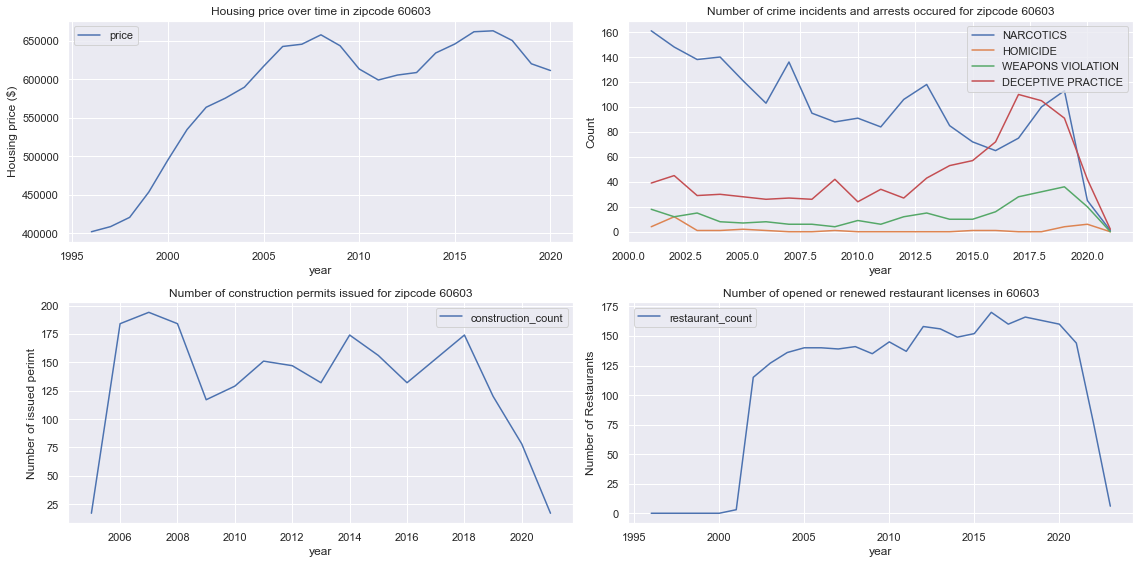

In [83]:
#Plotting all the information for a given zipcode 
def plot_data_for_zipcode(zipcode):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,8))
    df_price_by_zipcode_yearly[zipcode].plot(ax=ax1, title = 'Housing price over time in zipcode {}'.format(zipcode))
    ax1.set_ylabel('Housing price ($)')
    df_crime_by_zipcode_yealy[zipcode].plot(ax=ax2, title='Number of crime incidents and arrests occured for zipcode {}'.format(zipcode))
    ax2.set_ylabel('Count')
    df_construction_by_zipcode_yearly[zipcode].plot(ax=ax3, title ='Number of construction permits issued for zipcode {}'.format(zipcode))
    ax3.set_ylabel('Number of issued perimt')
    df_restaurants_by_zipcode_yearly[zipcode].plot(ax=ax4, title='Number of opened or renewed restaurant licenses in {}'.format(zipcode))
    ax4.set_ylabel('Number of Restaurants')
    plt.tight_layout()
plot_data_for_zipcode('60603')

In [84]:
def get_merged_data_yearly(zipcode):
    merged_df = pd.merge(df_price_by_zipcode_yearly[zipcode], df_crime_by_zipcode_yealy[zipcode].drop(['zipcode'], axis=1), right_index=True, left_index=True, how='inner').merge(df_construction_by_zipcode_yearly[zipcode].drop(['zipcode'], axis=1) ,right_index= True, left_index=True).merge(df_restaurants_by_zipcode_yearly[zipcode].drop(['zipcode'], axis=1), right_index=True, left_index=True)
    merged_df = merged_df[(merged_df.index>=2006) & (merged_df.index<=2019)]
    return merged_df
get_merged_data_yearly('60607').tail()

,zipcode,price,NARCOTICS,HOMICIDE,WEAPONS VIOLATION,DECEPTIVE PRACTICE,construction_count,restaurant_count
year,,,,,,,,
2015,60607,359979.833333,240.0,3.0,31.0,158.0,252,330.0
2016,60607,381571.666667,197.0,1.0,51.0,253.0,247,360.0
2017,60607,408474.666667,181.0,1.0,72.0,252.0,346,352.0
2018,60607,417524.083333,201.0,0.0,67.0,295.0,350,377.0
2019,60607,410625.250000,266.0,6.0,92.0,211.0,350,367.0


In [85]:
All_zipcodes_yearly_data_merged = pd.DataFrame()
for zipcode in Housing_price_yearly.zipcode.unique():
    temp_df = get_merged_data_yearly(zipcode)
    All_zipcodes_yearly_data_merged = pd.concat((All_zipcodes_yearly_data_merged, temp_df))

In [889]:
get_merged_data_yearly('60651').loc[2019,'price'] - get_merged_data_yearly('60651').loc[2016,'price']

58493.25

<a id=price-vs-other-plot></a>
### Relation between price and other features for a given time period
Below we plotted the scatter plot of the price and all the other features from 2014 to 2019 for all zipcodes. Each point represents a zipcode. We can see that as price increases the crime rate decreases for all crime types. However, after the median house price increases above 400K we see a slight increase in crime rate as well. This can show that for the most popular neighborhoods such as downtown area, due to the higher population theft and robbery increases as well.

Looking at the annotated price vs. battery plot, we can see that zip code 60633 is an outlier. Although it has one of the lowest housing prices the crime rate is pretty low. 

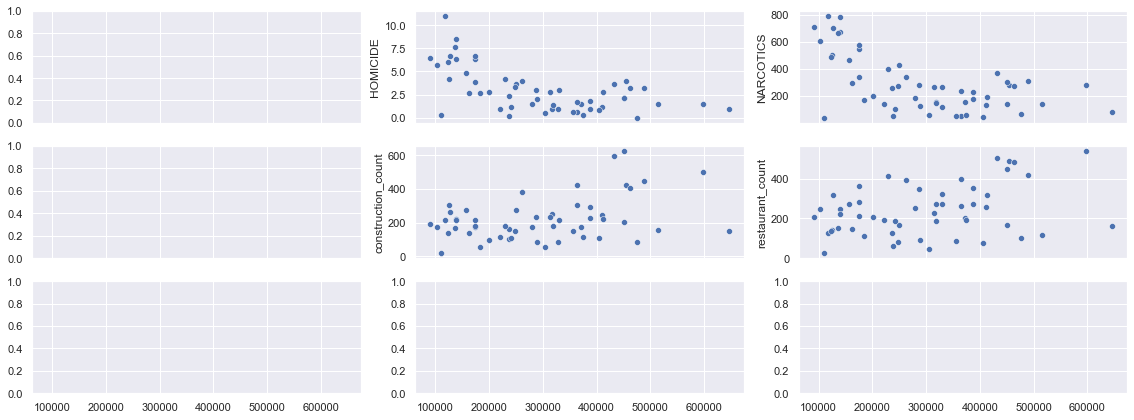

In [86]:
def plot_feature_price_relation(start_year=2014, end_year=2019):
    df = All_zipcodes_yearly_data_merged.loc[(All_zipcodes_yearly_data_merged.index>=start_year) & (All_zipcodes_yearly_data_merged.index<=end_year)]
    grouped_df = df.groupby('zipcode').mean()
    fig, ax = plt.subplots(3,3, figsize = (16,6), sharex=True)
#     sns.scatterplot(x='price', y='BATTERY', data=grouped_df, ax=ax[0,0])
    sns.scatterplot(x='price', y='HOMICIDE', data=grouped_df, ax=ax[0,1])
    sns.scatterplot(x='price', y='NARCOTICS', data=grouped_df, ax=ax[0,2])
#     sns.scatterplot(x='price', y='THEFT', data=grouped_df, ax=ax[1,0])
    sns.scatterplot(x='price', y='construction_count', data=grouped_df, ax=ax[1,1])
    sns.scatterplot(x='price', y='restaurant_count', data=grouped_df, ax=ax[1,2])
#     sns.scatterplot(x='price', y='BURGLARY', data=grouped_df, ax=ax[2,0])
#     sns.scatterplot(x='price', y='ROBBERY', data=grouped_df, ax=ax[2,1])
#     sns.scatterplot(x='price', y='CRIMINAL DAMAGE', data=grouped_df, ax=ax[2,2])
    plt.tight_layout()
plot_feature_price_relation()

In [87]:
#notes from the plots:

#Battery, NARCOTICS, and Homicide have 1/x ralation with housing price
#Theft has a (x - np.mean(x))**2 relation with housing price
#construction count has an almost x**2 relation with price

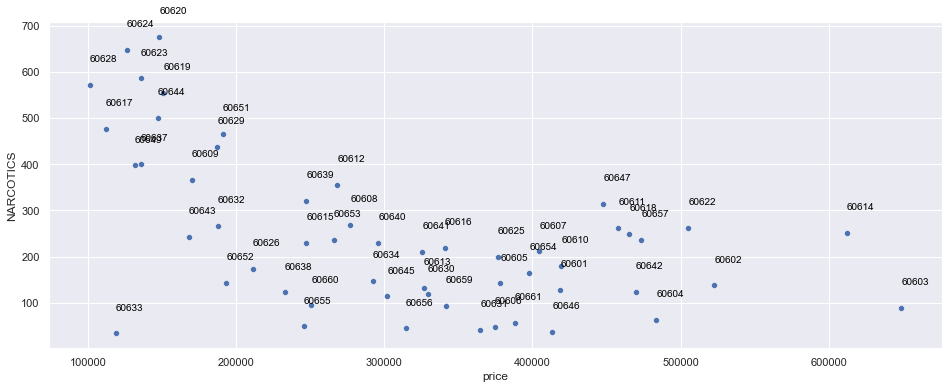

In [88]:
def plot_one_feature_price_relation(x='price', y='NARCOTICS', start_year=2016, end_year=2019):
    df = All_zipcodes_yearly_data_merged.loc[(All_zipcodes_yearly_data_merged.index>=start_year) & (All_zipcodes_yearly_data_merged.index<=end_year)]
    grouped_df = df.groupby('zipcode').mean()
    plt.figure(figsize=(16,6))
    sns.scatterplot(x=x, y=y, data=grouped_df)
    for zipcode in grouped_df.index:        
        plt.text(x=grouped_df.loc[zipcode,x]+50, y=grouped_df.loc[zipcode,y]+50, s=zipcode, horizontalalignment='left', size='small', color='black', weight='100')
plot_one_feature_price_relation()

In [89]:
#from the above plot we can see that zipcode 60633 is an outlier

<a id=price-vs-other-correlation></a>

### Correlation plots

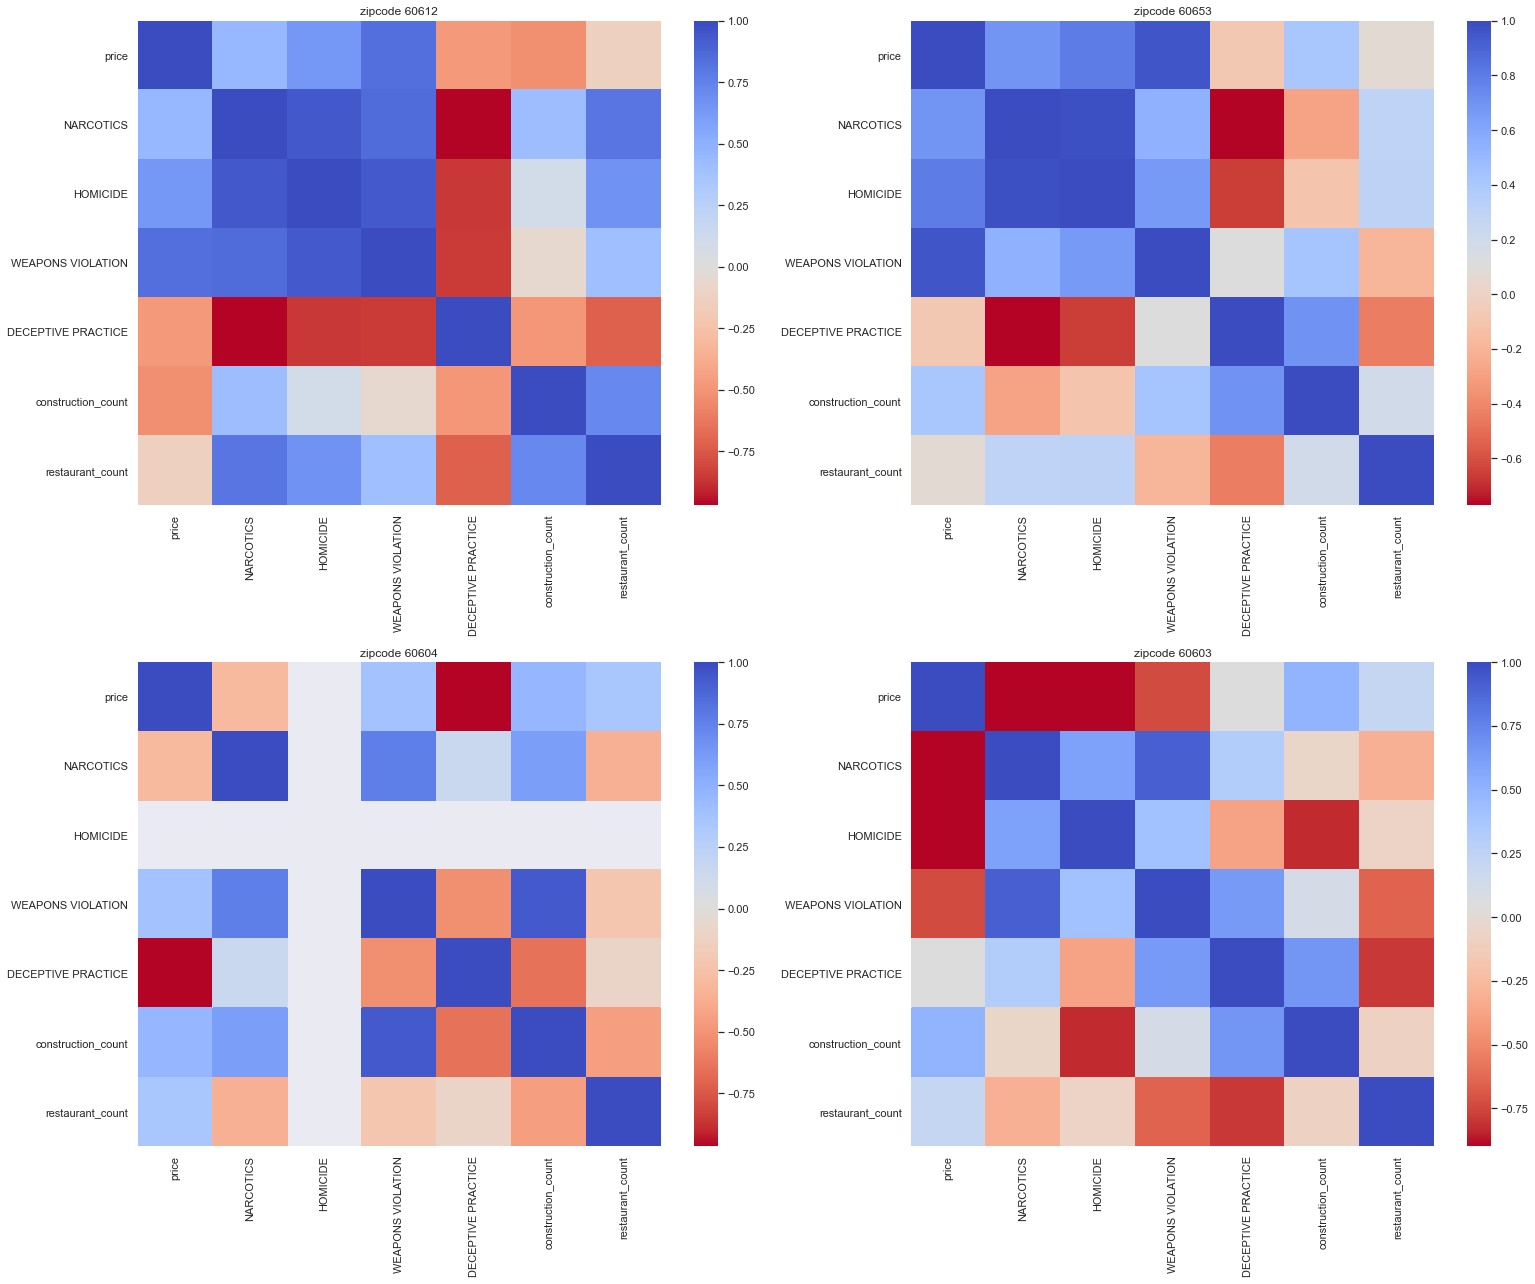

In [90]:
fig, ax = plt.subplots(2,2, figsize=(22,18))
chosen_zipcodes=['60612','60653', '60604', '60603']
idx=0
for i in range(2):
    for j in range(2):
        sns.heatmap(get_merged_data_yearly(chosen_zipcodes[idx]).loc[2016:2019].corr(), cmap="coolwarm_r",annot=False, ax=ax[i,j]).set( title="zipcode {}".format(chosen_zipcodes[idx]))
        idx +=1
plt.tight_layout()
       

In [91]:
# all zipcodes average value
all_zipcodes_df = pd.DataFrame()
for zipcode in Housing_price_yearly.zipcode.unique():
    one_zipcode_df = get_merged_data_yearly(zipcode)
    all_zipcodes_df = pd.concat((all_zipcodes_df, one_zipcode_df))

In [806]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from xgboost import plot_importance
import sklearn
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

In [807]:
df = get_merged_data_yearly('60608')
df.head(3)

,zipcode,price,NARCOTICS,HOMICIDE,WEAPONS VIOLATION,DECEPTIVE PRACTICE,construction_count,restaurant_count
year,,,,,,,,
2006,60608,301100.916667,1228.0,13.0,103.0,331.0,360,394.0
2007,60608,306468.416667,1350.0,1.0,72.0,309.0,337,391.0
2008,60608,283335.083333,883.0,1.0,78.0,293.0,326,346.0


<a id=feature-engineering></a>
### Feature engineering

To identify the trendy neighborhood in advance, we find the lagged feature values for the previous 3, 4, and 5 years and add them as a feature to the dataframe. We also find the year by year change in features and add them as new features to the data. The model will look at the last 3 consecetive years information and will estimate the housing price in the next 3 years.

In [808]:
# def get_squared(df):
#     new_df = (df-df.median())**2
#     new_df.columns = map(lambda x: x+'_squared', df.columns)
#     return new_df

In [809]:
# creating a function to find lagged values and difference between different lagged valuesfor given years
def find_lagged(df, column_names, lagged_years = [3,5]):
    df_lagged = pd.DataFrame()
    for column in column_names:
        for lag in lagged_years:
            df_lagged['{}_lag{}_value'.format(column, lag)] = df[column].shift(lag)
    return df_lagged.dropna()
column_names_for_lag = df.columns[1:]
df_lagged = find_lagged(df, column_names_for_lag)
df_lagged.head(3)


,price_lag3_value,price_lag5_value,NARCOTICS_lag3_value,NARCOTICS_lag5_value,HOMICIDE_lag3_value,HOMICIDE_lag5_value,WEAPONS VIOLATION_lag3_value,WEAPONS VIOLATION_lag5_value,DECEPTIVE PRACTICE_lag3_value,DECEPTIVE PRACTICE_lag5_value,construction_count_lag3_value,construction_count_lag5_value,restaurant_count_lag3_value,restaurant_count_lag5_value
year,,,,,,,,,,,,,,
2011,283335.083333,301100.916667,883.0,1228.0,1.0,13.0,78.0,103.0,293.0,331.0,326.0,360.0,346.0,394.0
2012,249957.500000,306468.416667,836.0,1350.0,2.0,1.0,73.0,72.0,297.0,309.0,264.0,337.0,389.0,391.0
2013,230831.833333,283335.083333,806.0,883.0,1.0,1.0,90.0,78.0,263.0,293.0,275.0,326.0,339.0,346.0


In [810]:
def find_change(df_lagged, column_names):
    for column in column_names:
#         df_lagged['{}_change_lag3_lag4'.format(column)] = df_lagged['{}_lag3_value'.format(column)] - df_lagged['{}_lag4_value'.format(column)]
        df_lagged['{}_change_lag3_lag5'.format(column)] = df_lagged['{}_lag3_value'.format(column)] - df_lagged['{}_lag5_value'.format(column)]
    return df_lagged
        
column_names_for_change = ['price', 'construction_count', 'restaurant_count', 'HOMICIDE', 'NARCOTICS']
df_with_lag_and_change = find_change(df_lagged, column_names_for_change)
df_with_lag_and_change.head(3)



,price_lag3_value,price_lag5_value,NARCOTICS_lag3_value,NARCOTICS_lag5_value,HOMICIDE_lag3_value,HOMICIDE_lag5_value,WEAPONS VIOLATION_lag3_value,WEAPONS VIOLATION_lag5_value,DECEPTIVE PRACTICE_lag3_value,DECEPTIVE PRACTICE_lag5_value,construction_count_lag3_value,construction_count_lag5_value,restaurant_count_lag3_value,restaurant_count_lag5_value,price_change_lag3_lag5,construction_count_change_lag3_lag5,restaurant_count_change_lag3_lag5,HOMICIDE_change_lag3_lag5,NARCOTICS_change_lag3_lag5
year,,,,,,,,,,,,,,,,,,,
2011,283335.083333,301100.916667,883.0,1228.0,1.0,13.0,78.0,103.0,293.0,331.0,326.0,360.0,346.0,394.0,-17765.833333,-34.0,-48.0,-12.0,-345.0
2012,249957.500000,306468.416667,836.0,1350.0,2.0,1.0,73.0,72.0,297.0,309.0,264.0,337.0,389.0,391.0,-56510.916667,-73.0,-2.0,1.0,-514.0
2013,230831.833333,283335.083333,806.0,883.0,1.0,1.0,90.0,78.0,263.0,293.0,275.0,326.0,339.0,346.0,-52503.250000,-51.0,-7.0,0.0,-77.0


In [812]:
#removing 60633 zipcode from data
# all_zipcodes_without_outlier = list(set(Housing_price_yearly.zipcode.unique())-set(['60633']))
all_zipcodes_without_outlier = Housing_price_yearly.zipcode.unique()

<a id=test-train-split></a>
### Splitting data into test and train

In [813]:
def Split_data(column_names_for_lag, column_names_for_change, split=0.85):
    X_train = pd.DataFrame()
    X_test = pd.DataFrame()
    y_train = pd.Series(dtype=float)
    y_test = pd.Series(dtype=float)
    indx = int(len(df_with_lag_and_change)*split)
    for zipcode in all_zipcodes_without_outlier:
        temp_df = get_merged_data_yearly(zipcode)  
        temp_df['NARCOTICS_squared'] = (temp_df['NARCOTICS'] - temp_df['price'].mean())**2
#         temp_df['BATTERY_squared'] = (temp_df['BATTERY'] - temp_df['BATTERY'].mean())**2
        temp_df['HOMICIDE_squared'] = (temp_df['HOMICIDE'] - temp_df['price'].mean())**2
#         temp_df['THEFT_squared'] = (temp_df['THEFT'] - temp_df['THEFT'].mean())**2
        temp_df['construction_count_squared'] = temp_df['construction_count']**2
        temp_df['restaurant_count_squared'] = temp_df['restaurant_count']**2
        y = temp_df.loc[temp_df.index>=2011, 'price']
        temp_df_lagged = find_lagged(temp_df, column_names_for_lag)
        temp_df_lagged = find_change(temp_df_lagged, column_names_for_change)
#         temp_df_lagged = find_lagged(temp_df, temp_df.columns[1:])
#         temp_df_lagged = find_change(temp_df_lagged, temp_df.columns[1:])
        temp_df_lagged = pd.merge(temp_df_lagged, temp_df.drop(['price'], axis=1), right_index=True, left_index=True)
        temp_df_lagged['zipcode'] = zipcode
        X_train = pd.concat([X_train,temp_df_lagged.iloc[:indx]])
        X_test = pd.concat([X_test, temp_df_lagged.iloc[indx:]])
        
        y_train = pd.concat([y_train, y.iloc[:indx]])
        y_test = pd.concat([y_test, y.iloc[indx:]])
    return X_train, X_test, y_train, y_test

column_names_for_change = ['price','construction_count', 'restaurant_count']
column_names_for_lag = ['price', 'construction_count', 'restaurant_count']

# column_names_for_change = get_merged_data_yearly('60608').columns[1:]
# column_names_for_lag = get_merged_data_yearly('60608').columns[1:]
X_train, X_test, y_train, y_test = Split_data(column_names_for_lag = column_names_for_lag, column_names_for_change = column_names_for_change)

In [814]:
### adding the zipcode data to the time series data

In [815]:
X_train = pd.merge(X_train, some_zipcode_extra_info, right_on='zipcode', left_on='zipcode', how='left')
X_test = pd.merge(X_test, some_zipcode_extra_info, right_on='zipcode', left_on='zipcode', how='left')

X_train_zipcode = X_train.zipcode
X_test_zipcode = X_test.zipcode

X_train = X_train.drop(['zipcode'], axis=1)
X_test = X_test.drop(['zipcode'], axis=1)

In [816]:
X_train = X_train.drop(['price_lag3_value', 'price_lag5_value'], axis=1)
price_lag3_value = X_test.price_lag3_value
X_test = X_test.drop(['price_lag3_value', 'price_lag5_value'], axis=1)


In [817]:
X_train.corr()[X_train.corr()>=0.8]

,construction_count_lag3_value,construction_count_lag5_value,restaurant_count_lag3_value,restaurant_count_lag5_value,price_change_lag3_lag5,construction_count_change_lag3_lag5,restaurant_count_change_lag3_lag5,NARCOTICS,HOMICIDE,WEAPONS VIOLATION,...,South Side,Humboldt Park,West Town,Near West Side,Chicago Loop,Central Chicago,Near North,Albany Park,Austin,Portage Park
construction_count_lag3_value,1.000000,0.846348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
construction_count_lag5_value,0.846348,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
restaurant_count_lag3_value,NaN,NaN,1.000000,0.991422,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
restaurant_count_lag5_value,NaN,NaN,0.991422,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price_change_lag3_lag5,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
construction_count_change_lag3_lag5,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
restaurant_count_change_lag3_lag5,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NARCOTICS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HOMICIDE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WEAPONS VIOLATION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [818]:
X_train.shape 

(378, 31)

In [819]:
X_train

,construction_count_lag3_value,construction_count_lag5_value,restaurant_count_lag3_value,restaurant_count_lag5_value,price_change_lag3_lag5,construction_count_change_lag3_lag5,restaurant_count_change_lag3_lag5,NARCOTICS,HOMICIDE,WEAPONS VIOLATION,...,South Side,Humboldt Park,West Town,Near West Side,Chicago Loop,Central Chicago,Near North,Albany Park,Austin,Portage Park
0,221.0,214.0,229.0,231.0,-3323.166667,7.0,-2.0,141.0,0.0,11.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,148.0,232.0,236.0,232.0,-26958.833333,-84.0,4.0,160.0,1.0,17.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,152.0,221.0,248.0,229.0,-42349.833333,-69.0,19.0,198.0,0.0,9.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,181.0,148.0,241.0,236.0,-51144.416667,33.0,5.0,167.0,1.0,17.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,185.0,152.0,260.0,248.0,-36021.750000,33.0,12.0,126.0,1.0,23.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,105.0,102.0,165.0,129.0,-34688.333333,3.0,36.0,100.0,0.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
374,110.0,89.0,183.0,162.0,-28608.833333,21.0,21.0,69.0,0.0,8.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
375,86.0,105.0,174.0,165.0,-23485.833333,-19.0,9.0,67.0,0.0,6.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
376,89.0,110.0,181.0,183.0,27160.083333,-21.0,-2.0,35.0,0.0,13.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


<a id=modeling></a>
# Modeling


<a id=vanilla-models></a>
### Trying vanilla models

We try some vanilla models to see which ones have a better initial performance. we can see that the ensembe models, random forest and xgboost have a lower error and higher r squared value. The Elastic net model also had a good performance compare to the other ones but we continue the modeling with the two top models.

In [820]:
def vanilla_model_performance(model):
    results = defaultdict(str)
    rf_pipe = Pipeline([('scaler', StandardScaler()),
                        ('model', model)])
    scoring = ['r2','neg_mean_absolute_error', 'neg_root_mean_squared_error']
    rf_cv = cross_validate(rf_pipe, X_train, y_train, cv=3, n_jobs=-1, scoring=scoring)
    return rf_cv['test_r2'].mean(), rf_cv['test_neg_mean_absolute_error'].mean()*(-1), rf_cv['test_neg_root_mean_squared_error'].mean()*(-1)


In [821]:
models = [DummyRegressor(),Lasso(), Ridge(), ElasticNet(), RandomForestRegressor(n_estimators=200), SVR(), xgb.XGBRegressor(n_estimators=200)]
performance = []
for model in models:
    performance.append(vanilla_model_performance(model))
vanilla_model_performance_results_df = pd.DataFrame(performance, columns = ['r2', 'mae', 'rmse'], index=['DummyRegressor','Lasso', 'Ridge', 'ElasticNet', 'RandomForestRegressor', 'SVR', 'XGBRegressor'])
vanilla_model_performance_results_df

,r2,mae,rmse
DummyRegressor,-0.626063,121635.929471,143331.003208
Lasso,0.904866,25447.614868,35294.277483
Ridge,0.911632,24525.746242,34020.948487
ElasticNet,0.873126,30548.276052,40254.038110
RandomForestRegressor,0.892449,23903.742081,36325.269882
SVR,-0.680551,123969.361964,146415.393150
XGBRegressor,0.918605,21396.636746,32053.583169


In [822]:
# RIDGE MODEL

In [823]:
ridge_param_grid = {'ridge__alpha':[10,100,1000]}
ridge_pipe = Pipeline([('scaler', StandardScaler()),
                    ('ridge', Ridge())])

# cv = sklearn.model_selection.RepeatedKFold(n_splits=3, n_repeats=3)
ridge_grid = GridSearchCV(ridge_pipe, param_grid=ridge_param_grid, cv=3, scoring='neg_mean_absolute_error')
ridge_grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': [10, 100, 1000]},
             scoring='neg_mean_absolute_error')

In [824]:
ridge_grid.best_params_

{'ridge__alpha': 10}

In [825]:
print(f'train MAE: {-1*round(ridge_grid.score(X_train, y_train))}')
y_pred = ridge_grid.predict(X_test)
print(f'test MAE: {round(mean_absolute_error(y_test,y_pred))}')
print(f'test RMSE: {round(np.sqrt(mean_squared_error(y_test,y_pred)))}')
print(f'r_squared: {r2_score(y_test,y_pred)}')

train MAE: 15397
test MAE: 32792
test RMSE: 39195
r_squared: 0.9092129913200104


In [826]:
#feature importance
ridge_feature_importances = abs(ridge_grid.best_estimator_.named_steps.ridge.coef_)/sum(abs(ridge_grid.best_estimator_.named_steps.ridge.coef_))
ridge_feature_importances_df = pd.DataFrame(ridge_feature_importances.reshape(1,-1), columns=X_train.columns).T.sort_values(by=0,ascending=False)
ridge_feature_importances_df.columns = ['feature_importance']
ridge_feature_importances_df.head(10)
# ridge_feature_importances_df.tail(10)


,feature_importance
NARCOTICS_squared,0.194784
HOMICIDE_squared,0.194718
construction_count,0.104317
price_change_lag3_lag5,0.058086
NARCOTICS,0.045447
restaurant_count,0.039072
construction_count_lag5_value,0.031723
construction_count_squared,0.031526
construction_count_change_lag3_lag5,0.029076
WEAPONS VIOLATION,0.028441


Text(0, 0.5, 'error ($)')

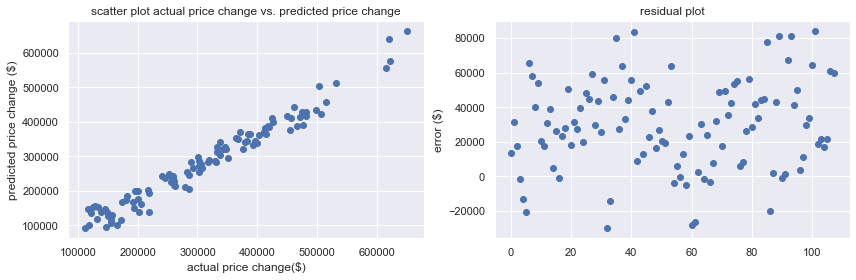

In [827]:
#residual and prediction plots
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14,4))
ax1.scatter(x=y_test, y =y_pred, marker='o')
ax1.set_xlabel('actual price change($)')
ax1.set_ylabel('predicted price change ($)')
ax1.set_title('scatter plot actual price change vs. predicted price change')
ax2.scatter(x=np.arange(len(y_test)), y = y_test - y_pred)
ax2.set_title('residual plot')
ax2.set_ylabel('error ($)')
# ax1.set_ylim([-40000,120000])
# ax1.set_xlim([-40000,120000])

In [828]:
ls_pipe = Pipeline([('scaler', StandardScaler()),
                        ('lasso', Lasso(alpha=0.1))])
ls_pipe.fit(X_train,y_train)

/opt/homebrew/anaconda3/envs/springboard/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21621319955.407974, tolerance: 638639270.5946449
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('scaler', StandardScaler()), ('lasso', Lasso(alpha=0.1))])

In [829]:
ls_pipe['lasso'].coef_

array([ -7746.31899736,  -9400.60470379, -10379.95516144,   -238.57601501,
        15346.74104942,   7616.71161119,   4447.40670166, -11891.96958271,
        -2238.64779664,  -8191.84380608,  -9542.44668781,  52833.27335281,
        30752.02709186, 106989.43433944,   -121.80056639, -24885.90444881,
       -22185.08004815,   2371.52725221,   4435.29701155,  -7971.62214323,
         1033.365371  ,  -2920.53444281,   4959.23824354,  -1862.75570458,
          739.81602042,   1406.22496407,  -6254.70313605,   2299.62650562,
         1855.95589463,   -642.03528623,   -953.70354956])

<a id=random-forest></a>
### Random forest

We use RandomizedSearchCV for hyper parameter tuning.

In [830]:
#RANDOM FOREST MODEL Hyperparameter tunning

#Finding the optimum hyperparameters for random forest model
rf_param_grid = {'forest__n_estimators':[50,60,80,100,120,150],'forest__max_depth':np.arange(5,50,10), 'forest__min_samples_leaf':[3,4,5,6,8], 'forest__max_samples':np.arange(0.05,0.95,0.1)}
rf_pipe = Pipeline([('scaler', StandardScaler()),
                    ('forest', RandomForestRegressor())])
cv = sklearn.model_selection.KFold(n_splits=4, shuffle=False)
rf_grid = RandomizedSearchCV(rf_pipe, param_distributions=rf_param_grid, cv=cv, n_iter=250, n_jobs=-1, scoring='neg_mean_absolute_error')
rf_grid.fit(X_train, y_train)


RandomizedSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('forest',
                                              RandomForestRegressor())]),
                   n_iter=250, n_jobs=-1,
                   param_distributions={'forest__max_depth': array([ 5, 15, 25, 35, 45]),
                                        'forest__max_samples': array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85]),
                                        'forest__min_samples_leaf': [3, 4, 5, 6,
                                                                     8],
                                        'forest__n_estimators': [50, 60, 80,
                                                                 100, 120,
                                                                 150]},
                   scoring='neg_mean_absolute_error')

In [831]:
rf_results = pd.DataFrame(rf_grid.cv_results_)
rf_results = rf_results[['params', 'rank_test_score', 'mean_test_score', 'std_test_score', 
                   'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score']].sort_values(by=['rank_test_score'])
rf_results

,params,rank_test_score,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score
237,"{'forest__n_estimators': 100, 'forest__min_sam...",1,-20423.319897,5760.654136,-29903.186135,-18394.386631,-14352.868429,-19042.838394
78,"{'forest__n_estimators': 150, 'forest__min_sam...",2,-20714.971899,6153.809818,-30805.554931,-18773.111922,-14122.081902,-19159.138841
80,"{'forest__n_estimators': 60, 'forest__min_samp...",3,-21044.836590,6830.617686,-32383.130207,-18157.948125,-14171.002580,-19467.265449
109,"{'forest__n_estimators': 80, 'forest__min_samp...",4,-21079.468929,6881.768306,-32591.437871,-18533.987413,-14334.468533,-18857.981898
81,"{'forest__n_estimators': 150, 'forest__min_sam...",5,-21161.830000,6255.989429,-31553.600855,-18829.733760,-14825.169862,-19438.815525
...,...,...,...,...,...,...,...,...
190,"{'forest__n_estimators': 150, 'forest__min_sam...",246,-116596.594511,26894.481467,-149318.754728,-136195.647040,-96336.634397,-84535.341879
126,"{'forest__n_estimators': 60, 'forest__min_samp...",247,-116678.257286,26078.609609,-148179.264846,-135630.882346,-98382.368773,-84520.513178
153,"{'forest__n_estimators': 60, 'forest__min_samp...",248,-117304.628810,27754.322566,-151323.194978,-137332.412286,-95864.050808,-84698.857168
53,"{'forest__n_estimators': 80, 'forest__min_samp...",249,-117805.103563,27612.907914,-151719.261721,-137370.214160,-97657.546408,-84473.391963


In [832]:
#best parameters
rf_grid.best_params_

{'forest__n_estimators': 100,
 'forest__min_samples_leaf': 3,
 'forest__max_samples': 0.8500000000000002,
 'forest__max_depth': 15}

In [833]:
print(f'train MAE: {-1*rf_grid.score(X_train, y_train)}')
y_pred = rf_grid.predict(X_test)
print(f'test MAE: {mean_absolute_error(y_test,y_pred)}')
print(f'test RMSE: {np.sqrt(mean_squared_error(y_test,y_pred))}')
print(f'r_squared: {r2_score(y_test,y_pred)}')

train MAE: 7443.7100055693645
test MAE: 23419.425601130126
test RMSE: 26366.972156014057
r_squared: 0.9589152496025812


In [834]:
#feature importance
rf_feature_importances = rf_grid.best_estimator_.named_steps.forest.feature_importances_
rf_feature_importances_df = pd.DataFrame(rf_feature_importances.reshape(1,-1), columns=X_train.columns).T.sort_values(by=0,ascending=False)
rf_feature_importances_df.head(10)

,0
NARCOTICS_squared,0.935188
HOMICIDE_squared,0.028121
construction_count_change_lag3_lag5,0.012111
price_change_lag3_lag5,0.011174
NARCOTICS,0.005501
construction_count_lag5_value,0.001381
restaurant_count_change_lag3_lag5,0.001002
DECEPTIVE PRACTICE,0.000679
construction_count_lag3_value,0.000669
WEAPONS VIOLATION,0.000539


Text(0, 0.5, 'error ($)')

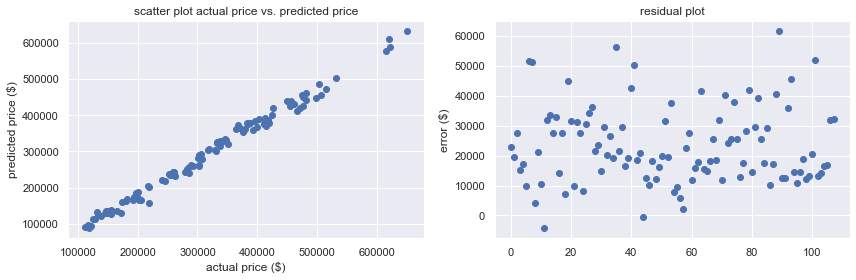

In [835]:
#residual and prediction plots
y_pred_rf = rf_pipe.fit(X_train,y_train).predict(X_test)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14,4))
ax1.scatter(x=y_test, y =y_pred_rf, marker='o')
ax1.set_xlabel('actual price ($)')
ax1.set_ylabel('predicted price ($)')
ax1.set_title('scatter plot actual price vs. predicted price')
ax2.scatter(x=np.arange(len(y_test)), y = y_test - y_pred_rf)
ax2.set_title('residual plot')
ax2.set_ylabel('error ($)')

In [836]:
# plt.figure(figsize=(16,8))
# sns.scatterplot(x=y_test.values, y=y_pred, hue=X_test_zipcode, style=X_test_zipcode,edgecolor='k' ,linewidth=0.4)
# plt.xlabel('actual price')
# plt.ylabel('predicted price')

<a id=xgboost></a>
### XGBOOST 

In [874]:
gbm_param_grid = {'gbm__learning_rate':[0.001, 0.01,0.1,1.0],
                  'gbm__n_estimators':[40,60],
                  'gbm__max_depth':np.arange(1,5,1),
                  'gbm__subsample': np.arange(0.01,0.6,0.01),
                  'gbm__colsample_bytree':np.arange(0.05,0.65,0.05),
                  'gbm__reg_lambda':[10,100],
                  
                  }
gbm = xgb.XGBRegressor()

xgb_pipe = Pipeline([('scaler', StandardScaler()),
                     ('gbm', gbm)])
cv = sklearn.model_selection.KFold(n_splits=3, shuffle=False)
gbm_grid = RandomizedSearchCV(xgb_pipe, param_distributions=gbm_param_grid, n_iter=1000, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
gbm_grid.fit(X_train,y_train)

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('gbm',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           gamma=None,
                                                           gpu_id=None,
                                                           importance_type='gain',
                                                           interaction_constraints=None,
                                                           learning_rate=None,
       

In [875]:
gbm_results = pd.DataFrame(gbm_grid.cv_results_)
gbm_results = gbm_results[['params', 'rank_test_score', 'mean_test_score', 'std_test_score', 
                   'split0_test_score', 'split1_test_score', 'split2_test_score']].sort_values(by=['rank_test_score'])
gbm_results

,params,rank_test_score,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score
720,"{'gbm__subsample': 0.38, 'gbm__reg_lambda': 10...",1,-24954.049272,13022.138537,-43075.391927,-13051.399161,-18735.356729
181,"{'gbm__subsample': 0.4, 'gbm__reg_lambda': 10,...",2,-25599.812445,11963.626662,-42469.138434,-16041.795160,-18288.503741
310,"{'gbm__subsample': 0.52, 'gbm__reg_lambda': 10...",3,-25749.377577,10637.777436,-40780.375765,-18777.278212,-17690.478753
180,"{'gbm__subsample': 0.43, 'gbm__reg_lambda': 10...",4,-25975.919147,11523.028416,-42098.380126,-15860.433366,-19968.943948
363,"{'gbm__subsample': 0.45, 'gbm__reg_lambda': 10...",5,-25980.505870,10032.608478,-40153.380353,-18322.167452,-19465.969804
...,...,...,...,...,...,...,...
315,"{'gbm__subsample': 0.01, 'gbm__reg_lambda': 10...",996,-266046.814755,60976.679496,-342893.642495,-193738.935961,-261507.865810
541,"{'gbm__subsample': 0.01, 'gbm__reg_lambda': 10...",996,-266046.814755,60976.679496,-342893.642495,-193738.935961,-261507.865810
844,"{'gbm__subsample': 0.01, 'gbm__reg_lambda': 10...",996,-266046.814755,60976.679496,-342893.642495,-193738.935961,-261507.865810
855,"{'gbm__subsample': 0.01, 'gbm__reg_lambda': 10...",996,-266046.814755,60976.679496,-342893.642495,-193738.935961,-261507.865810


In [876]:
#best parameters
# rf_grid.best_params_

In [877]:
#best parametrs
gbm_grid.best_params_

{'gbm__subsample': 0.38,
 'gbm__reg_lambda': 10,
 'gbm__n_estimators': 100,
 'gbm__max_depth': 4,
 'gbm__learning_rate': 0.1,
 'gbm__colsample_bytree': 0.5}

In [878]:
print(f'train MAE: {round(-1*gbm_grid.score(X_train, y_train))}')
y_pred_gbm = gbm_grid.predict(X_test)
print(f'test MAE: {round(mean_absolute_error(y_test,y_pred_gbm))}')
print(f'test RMSE: {round(np.sqrt(mean_squared_error(y_test,y_pred)))}')
print(f'r_squared: {round(r2_score(y_test,y_pred_gbm),2)}')

train MAE: 7910
test MAE: 21672
test RMSE: 26367
r_squared: 0.96


<AxesSubplot:>

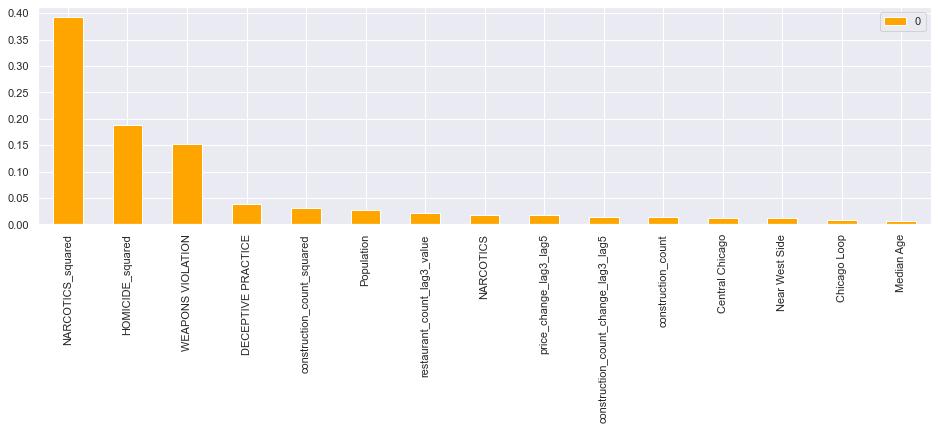

In [879]:
gbm_feature_importance_df = pd.DataFrame(gbm_grid.best_estimator_.named_steps.gbm.feature_importances_.reshape(1,-1), columns= X_train.columns.values)
sorted_gbm_feature_importance_df = gbm_feature_importance_df.T.sort_values(by=0,ascending=False)
sorted_gbm_feature_importance_df.head(15).plot(kind='bar', figsize=(16,4), color='orange')

In [880]:
gbm_feature_importance_df.T.sort_values(by=0,ascending=False)[:20]

,0
NARCOTICS_squared,0.392174
HOMICIDE_squared,0.188498
WEAPONS VIOLATION,0.151476
DECEPTIVE PRACTICE,0.039423
construction_count_squared,0.031169
Population,0.027494
restaurant_count_lag3_value,0.021185
NARCOTICS,0.018358
price_change_lag3_lag5,0.017604
construction_count_change_lag3_lag5,0.014426


Text(0, 0.5, 'error ($)')

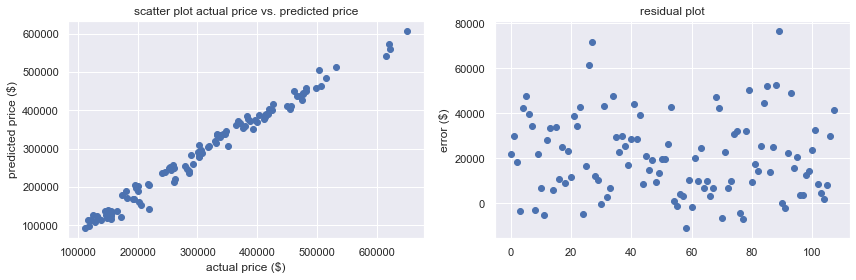

In [881]:
#residual and prediction plots
y_pred_gbm = gbm_grid.predict(X_test)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14,4))
ax1.scatter(x=y_test, y =y_pred_gbm, marker='o')
ax1.set_xlabel('actual price ($)')
ax1.set_ylabel('predicted price ($)')
ax1.set_title('scatter plot actual price vs. predicted price')
ax2.scatter(x=np.arange(len(y_test)), y = y_test - y_pred_gbm)
ax2.set_title('residual plot')
ax2.set_ylabel('error ($)')

In [858]:
### Finding zipcodes that will have maximum price increase in 5 years

In [859]:
def get_2019_prediction(model):
    X_train, X_test, y_train, y_test = Split_data(column_names_for_lag = column_names_for_lag, column_names_for_change = column_names_for_change, split=0.9)
    X_train = pd.merge(X_train, some_zipcode_extra_info, right_on='zipcode', left_on='zipcode', how='left')
    X_test = pd.merge(X_test, some_zipcode_extra_info, right_on='zipcode', left_on='zipcode', how='left')
    X_train_zipcode = X_train.zipcode
    X_test_zipcode = X_test.zipcode
    
    X_train = X_train.drop(['price_lag3_value', 'price_lag5_value'], axis=1)
    price_lag3_value = X_test.price_lag3_value
    X_test = X_test.drop(['price_lag3_value', 'price_lag5_value'], axis=1)
    
    X_train = X_train.drop(['zipcode'], axis=1)
    X_test = X_test.drop(['zipcode'], axis=1)
    y_pred_rf = model.predict(X_test)
    rf_result_df = pd.DataFrame()
    rf_result_df['zipcode'] = X_test_zipcode
    rf_result_df['price_lag3_value']= price_lag3_value
    rf_result_df['forecast'] = y_pred_rf
    rf_result_df['value_increase'] = rf_result_df.forecast - rf_result_df.price_lag3_value
    return rf_result_df.sort_values('value_increase', ascending=False).reset_index(drop=True)

get_2019_prediction(rf_grid).head(3) 

,zipcode,price_lag3_value,forecast,value_increase
0,60624,110954.416667,133789.381964,22834.965297
1,60623,115736.166667,135353.139180,19616.972513
2,60637,116039.083333,133364.011119,17324.927786


In [860]:
def num_zipcodes_correctly_found(model):
    correctly_predicted_zipcodes = [] 
    model_selected_zip = get_2019_prediction(model).zipcode.values[:10]
    for zipcode in price_change.zipcode[:10]:
        if zipcode in model_selected_zip:
            correctly_predicted_zipcodes.append(zipcode)
    return correctly_predicted_zipcodes
num_zipcodes_correctly_found(rf_grid)

['60612', '60609', '60639', '60623', '60624']

In [861]:
num_zipcodes_correctly_found(ridge_grid)

['60609', '60628', '60608']

In [862]:
num_zipcodes_correctly_found(gbm_grid)

['60609', '60628']

6 zipcodes detected by the model were among the top 10 zipcodes that had the maximum value growth over the 3 years period.

<a id=statistical-significance></a>
# Statistical Analysis

In [726]:
from scipy.stats import ttest_1samp
from statsmodels.stats import weightstats as stests

In [727]:
def finding_bootstap_samples(n):
    num_correct_zipcodes_in_sample = []
    for i in range(n):
        random_zipcodes = price_change.zipcode.sample(10)
        correct_zipcodes = len([zipcode for zipcode in random_zipcodes if zipcode in price_change.zipcode.values[:10]])
        num_correct_zipcodes_in_sample.append(correct_zipcodes)
    return num_correct_zipcodes_in_sample
bootstrap_sample =finding_bootstap_samples(10000)

In [728]:
np.percentile(bootstrap_sample, 90)

3.0

Text(0, 0.5, 'frequency')

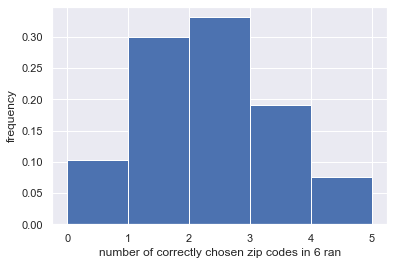

In [729]:
plt.hist(bootstrap_sample,bins=np.arange(6), density=True)
plt.xlabel('number of correctly chosen zip codes in 6 ran')
plt.ylabel('frequency')

In [730]:
tset, pval = ttest_1samp(bootstrap_sample, 5)
pval

0.0

In [ ]:
ztest, pval = stests.ztest(bootstrap_sample, x2=None, value=6)
print(float(pval))

In [ ]:
price_change.zipcode[:10].values

In [ ]:
sns.relplot()